# Data Pre-Processing

Import essential packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Read in `Results.csv`

In [2]:
df = pd.read_csv("./data/Results.csv", sep=";", decimal=",") # Separator is semi-colon and decimal point is comma

In [3]:
df.head()

tag           mode  quality  \
0  VRHYDV2.VEITUR_0004_PI-BAR  average:PT10M    100.0   
1  VRHYDV2.VEITUR_0001_PI-BAR  minimum:PT10M    100.0   
2  VRHYDV2.VEITUR_0003_PI-BAR  average:PT10M    100.0   
3  VRHYDV2.VEITUR_0003_PI-BAR  average:PT10M    100.0   
4  VRHYDV2.VEITUR_0003_PI-BAR  average:PT10M    100.0   

                      time  value  
0  2020-10-10 10:41:42.000   6.32  
1  2020-10-10 16:31:42.000   5.63  
2  2020-10-10 10:11:42.000   5.74  
3  2020-10-10 11:51:42.000   5.70  
4  2020-10-10 02:51:42.000   7.42

Convert the `time` field to `Pandas DateTime`

In [4]:
df.time      = pd.to_datetime(df.time)   # Convert datefield to datetime
df           = df.sort_values(by='time') # Sort values on the time column
df           = df.dropna()               # Remove NaNs (there's only one)

Separate the dataframe into device-unique instances (i.e. on sensor)

In [5]:
devices      = sorted(df.tag.unique())           # Create a list of sorted device tags, there are 4 sensors
device_names = [name[15:22] for name in devices] # Make a list of device unique names, i.e. 0001_PI, 0002_PI, ...
grouped      = df.groupby(df.tag)                # Create a groupby generator on the .tag column (sensor names)
dfs          = {}                                # Empty dictionary to hold device-unique dataframes

# For every unique device
for i, device in enumerate(devices):   
    # Add device unique group to dictionary. The key is device unique, i.e. 0001_PI, 0002_PI, ...
    dfs["{}".format(device_names[i])] = grouped.get_group(device).copy()

In [6]:
dfs['0001_PI'].head()

tag           mode  quality  \
779680  VRHYDV2.VEITUR_0001_PI-BAR  minimum:PT10M    100.0   
618811  VRHYDV2.VEITUR_0001_PI-BAR  maximum:PT10M    100.0   
307244  VRHYDV2.VEITUR_0001_PI-BAR  average:PT10M    100.0   
626227  VRHYDV2.VEITUR_0001_PI-BAR  minimum:PT10M    100.0   
756009  VRHYDV2.VEITUR_0001_PI-BAR  maximum:PT10M    100.0   

                      time  value  
779680 2019-06-06 00:00:00   5.22  
618811 2019-06-06 00:00:00   5.55  
307244 2019-06-06 00:00:00   5.39  
626227 2019-06-06 00:10:00   5.34  
756009 2019-06-06 00:10:00   5.67

This should be fine, but I'm not all too fond of this stacked format we have where the `average`, `minimum` and `maximum` values are in seperate rows.<br> 
I'll now *unstack* the dataframe so that these appear in different columns, by using `.pivot()`.

In [7]:
for key, dataframe in dfs.items():
    dfs[key] = dataframe.pivot(index="time", columns="mode", values=['value','quality']).copy()

The multi-index column names are a bit awkward, e.g. `maximum:PT10M` etc.<br>
I'll create a cleaner version and apply to all of them

In [8]:
# Create a list of easily interpretable tuples
new_columns = [('value','avg'),
               ('value','max'),
               ('value','min'),
               ('quality','q_avg'),
               ('quality','q_max'),
               ('quality','q_min')]

# And generate a multi-index out of it
column_idx  = pd.MultiIndex.from_tuples(new_columns)

# Apply it to all the device-unique dataframes in the dictionary
for key, dataframe in dfs.items():
    dataframe.columns = column_idx
    dataframe.columns = dataframe.columns.droplevel()

Now, I want to check if all the `quality` values of the frames are the same, if so, then some columns are redundant

In [9]:
dfs['0001_PI'].q_min.equals(dfs['0001_PI'].q_avg)

False

Hmm, unfortunately it seems **not**. <br>
Let's check where this mismatch is happening.

In [10]:
# Find the index numbers where the quality of the average value is not equal to the quality of the minimum one
mismatches = np.where(dfs['0001_PI'].q_min != dfs['0001_PI'].q_avg)[0]

# Display the row values where this is happening
dfs['0001_PI'].iloc[mismatches[0]]

avg         NaN
max        5.68
min        5.32
q_avg       NaN
q_max    100.00
q_min    100.00
Name: 2020-03-21 17:01:40, dtype: float64

Okay, strangely enough, there seem to be `NaNs` present in the average columns which are not reflected in the `max` and `min` ones.<br>
Maybe we need a clarification if there is some minimum number of measurements required to generate an average measurement.

In [11]:
dfs['0001_PI'].head()

avg   max   min  q_avg  q_max  q_min
time                                                      
2019-06-06 00:00:00  5.39  5.55  5.22  100.0  100.0  100.0
2019-06-06 00:10:00  5.54  5.67  5.34  100.0  100.0  100.0
2019-06-06 00:20:00  5.43  5.65  5.12  100.0  100.0  100.0
2019-06-06 00:30:00  5.55  5.75  5.36  100.0  100.0  100.0
2019-06-06 00:40:00  5.74  5.88  5.42  100.0  100.0  100.0

In [12]:
dfs['0001_PI'].describe()

avg            max            min          q_avg  \
count  102391.000000  101405.000000  101550.000000  102391.000000   
mean        5.509475       5.777625       5.355224      89.526423   
std         2.367803       2.341018       2.240667      30.621414   
min        -1.000000      -1.000000      -1.000000       0.000000   
25%         5.500000       5.810000       5.230000     100.000000   
50%         6.190000       6.450000       5.940000     100.000000   
75%         6.810000       7.030000       6.590000     100.000000   
max         7.920000      14.070000       7.830000     100.000000   

               q_max          q_min  
count  101405.000000  101550.000000  
mean       90.397909      90.410635  
std        29.462136      29.444679  
min         0.000000       0.000000  
25%       100.000000     100.000000  
50%       100.000000     100.000000  
75%       100.000000     100.000000  
max       100.000000     100.000000

In [13]:
def interval_plot(x, y, lower, upper, ylim=None, title='', xlabel='', ylabel='', color='r', figsize=(16,8), axes=None):
    
    if axes is None:        # Generate plot from definition
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize, dpi=400)
    
    if ylim is not None:    # Set y-boundary if defined
        axes.set_ylim(*ylim)
    
    axes.set_title(title)   # Set title
    axes.set_xlabel(xlabel) # Mark axes
    axes.set_ylabel(ylabel) 

    axes.grid()                                                # Turn on grid
    axes.fill_between(x, lower, upper, alpha=0.2, color=color) # Main data line
    axes.plot(x, y, color=color)                               # Shaded interval
    
    return axes

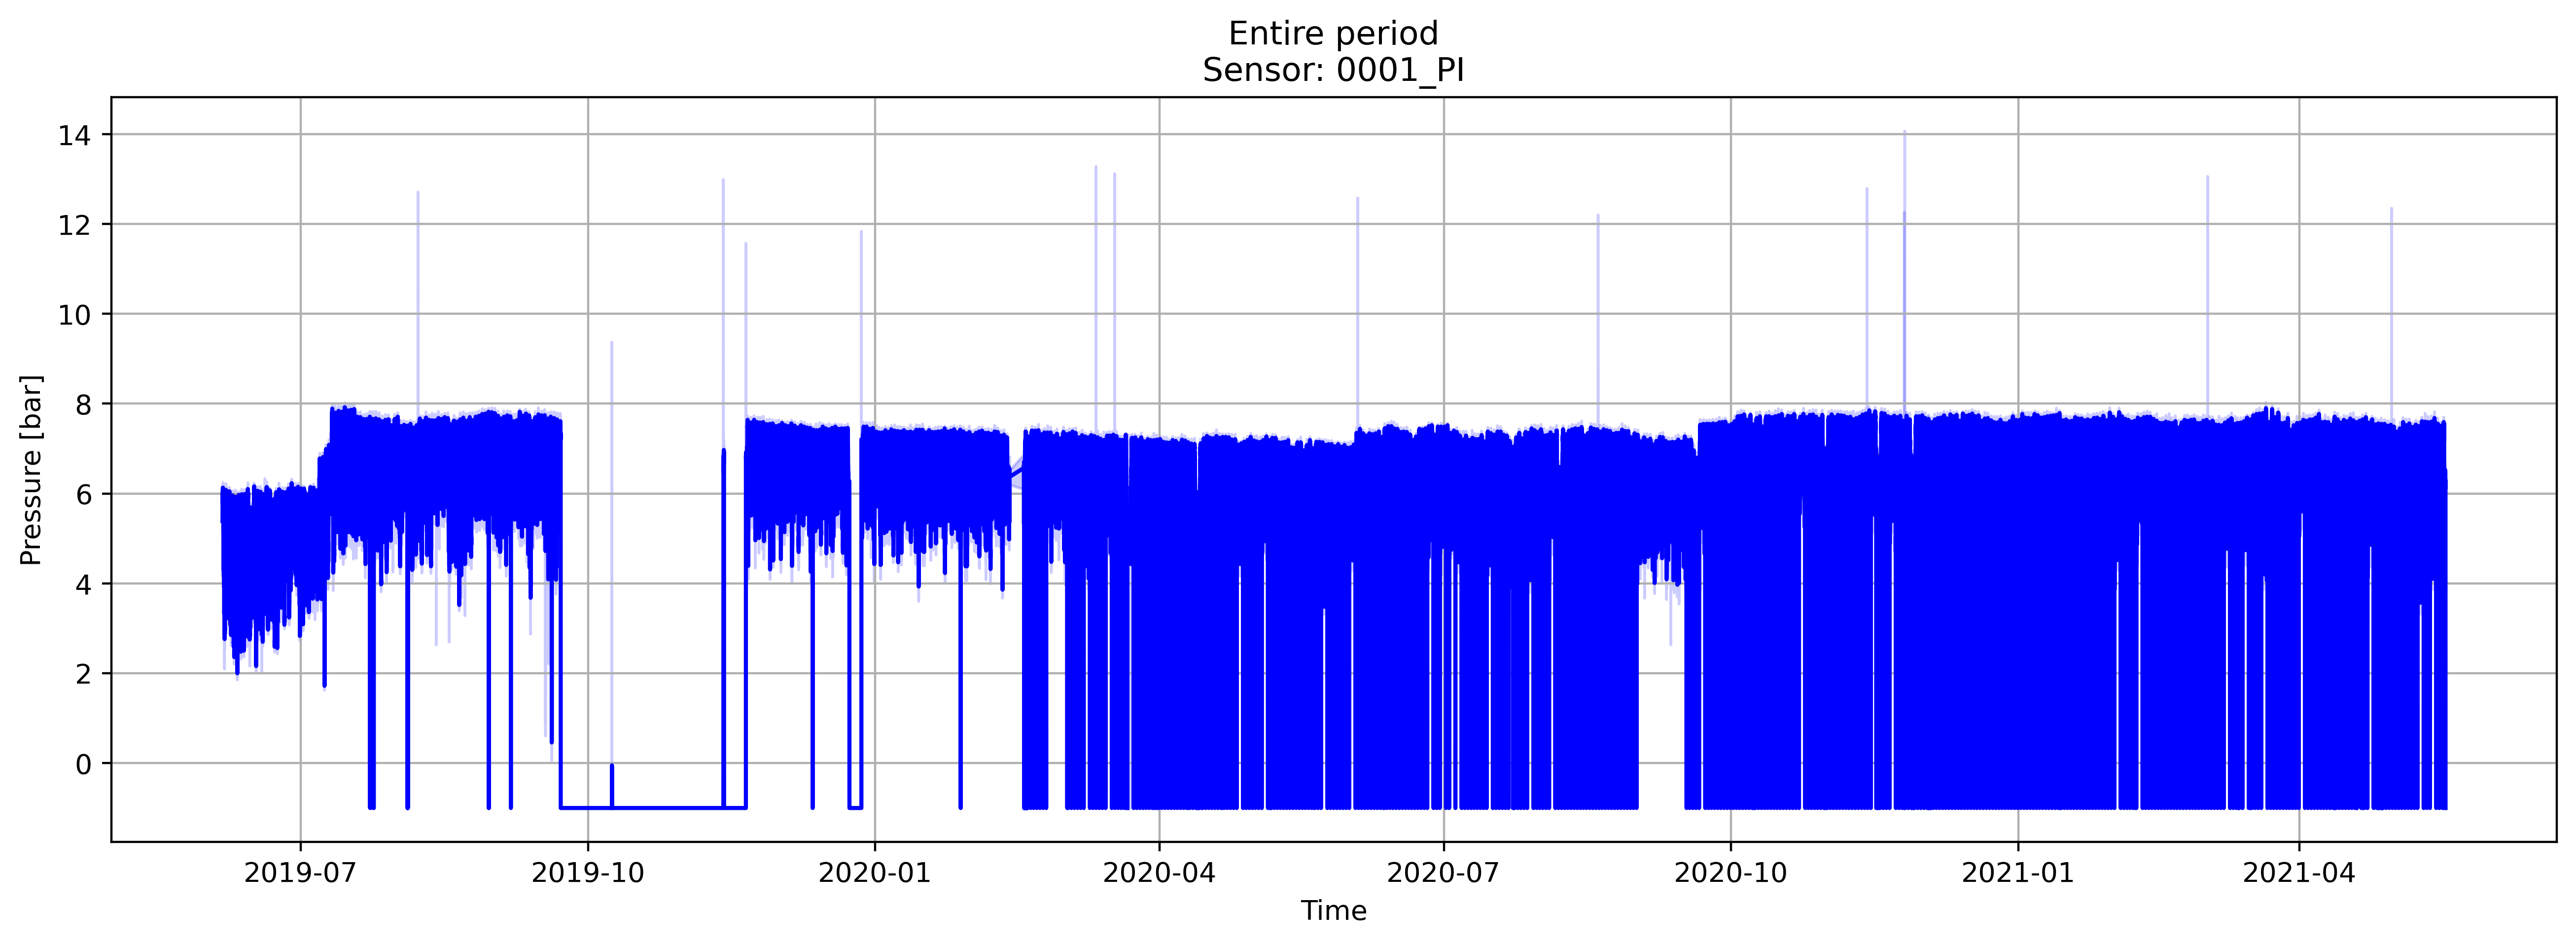

In [14]:
ax = interval_plot(x       = dfs['0001_PI'].index, 
                   y       = dfs['0001_PI']['avg'], 
                   lower   = dfs['0001_PI']['min'], 
                   upper   = dfs['0001_PI']['max'],
                   ylim    = None,
                   title   = 'Entire period\nSensor: 0001_PI',
                   xlabel  = 'Time',
                   ylabel  = 'Pressure [bar]',
                   color   = 'b', 
                   figsize = (16,5))

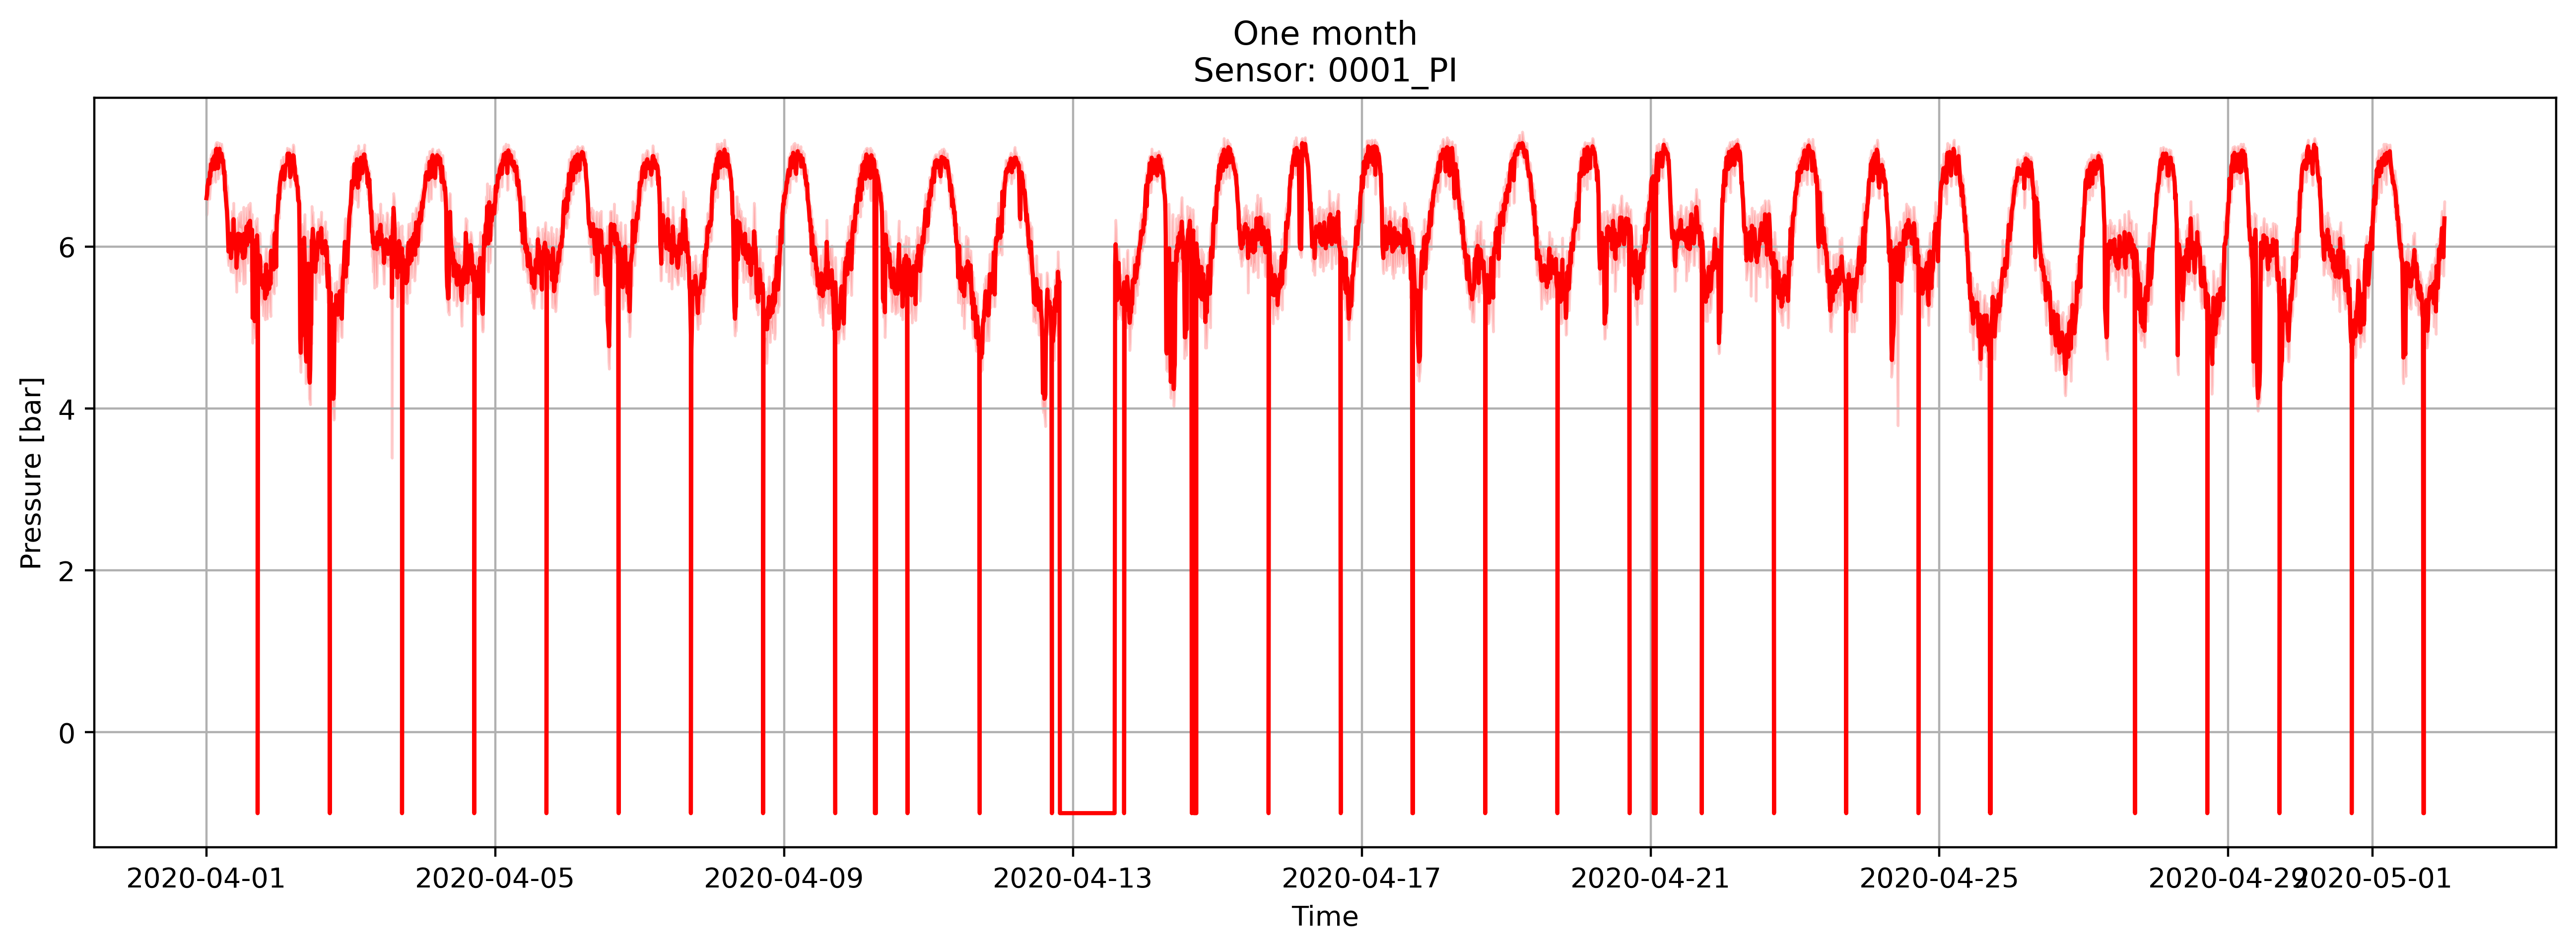

In [15]:
ax = interval_plot(x       = dfs['0001_PI']['2020-04-01':'2020-05-01'].index, 
                   y       = dfs['0001_PI']['2020-04-01':'2020-05-01']['avg'], 
                   lower   = dfs['0001_PI']['2020-04-01':'2020-05-01']['min'], 
                   upper   = dfs['0001_PI']['2020-04-01':'2020-05-01']['max'],
                   ylim    = None,
                   title   = 'One month\nSensor: 0001_PI',
                   xlabel  = 'Time',
                   ylabel  = 'Pressure [bar]',
                   color   = 'r', 
                   figsize = (16,5))

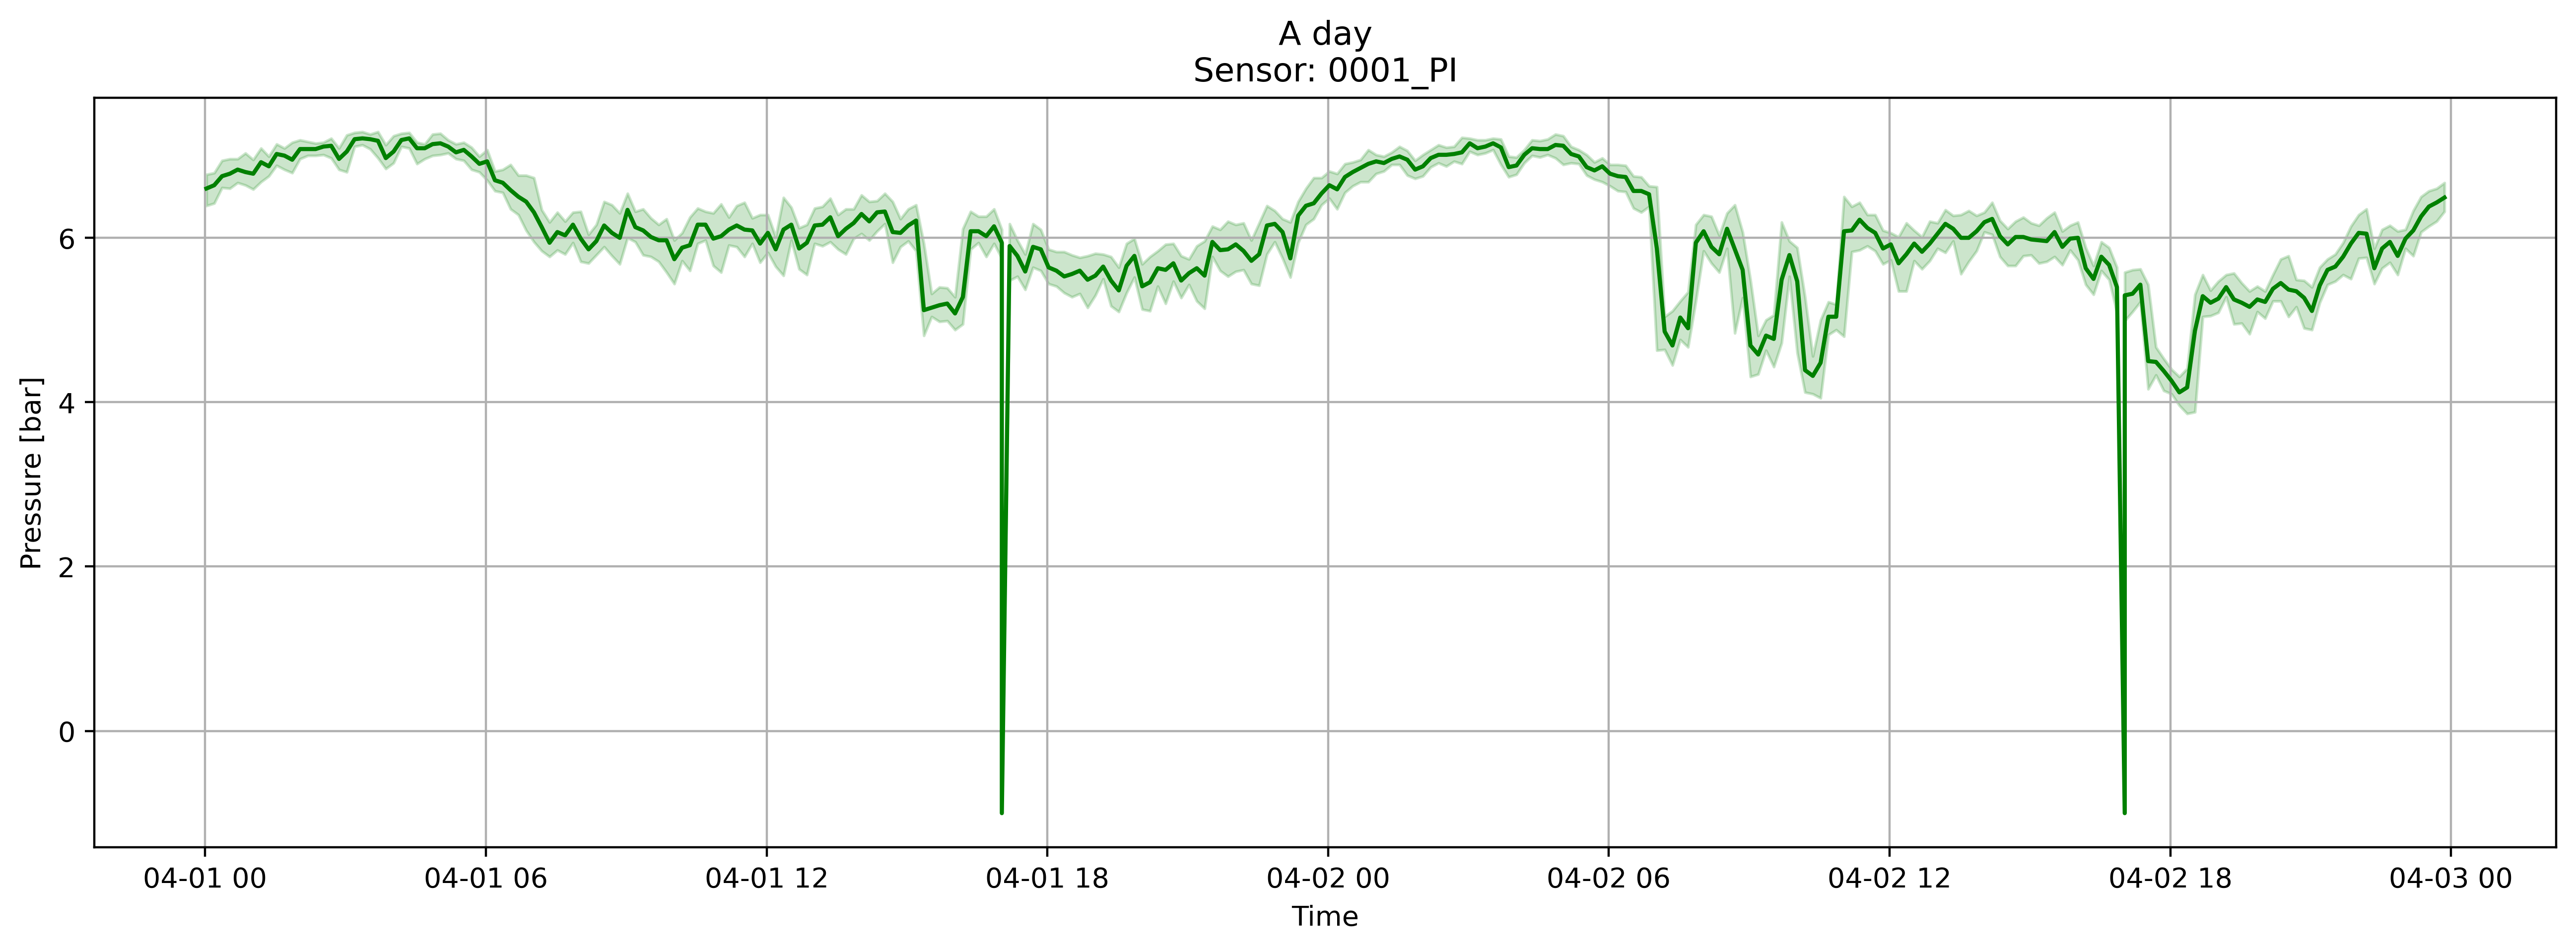

In [16]:
ax = interval_plot(x       = dfs['0001_PI']['2020-04-01':'2020-04-02'].index, 
                   y       = dfs['0001_PI']['2020-04-01':'2020-04-02']['avg'], 
                   lower   = dfs['0001_PI']['2020-04-01':'2020-04-02']['min'], 
                   upper   = dfs['0001_PI']['2020-04-01':'2020-04-02']['max'],
                   ylim    = None,
                   title   = 'A day\nSensor: 0001_PI',
                   xlabel  = 'Time',
                   ylabel  = 'Pressure [bar]',
                   color   = 'g', 
                   figsize = (16,5))

These sudden pressure surges at 17:00 are a bit suspicious. <br>
They seem to be present on on all the sensors

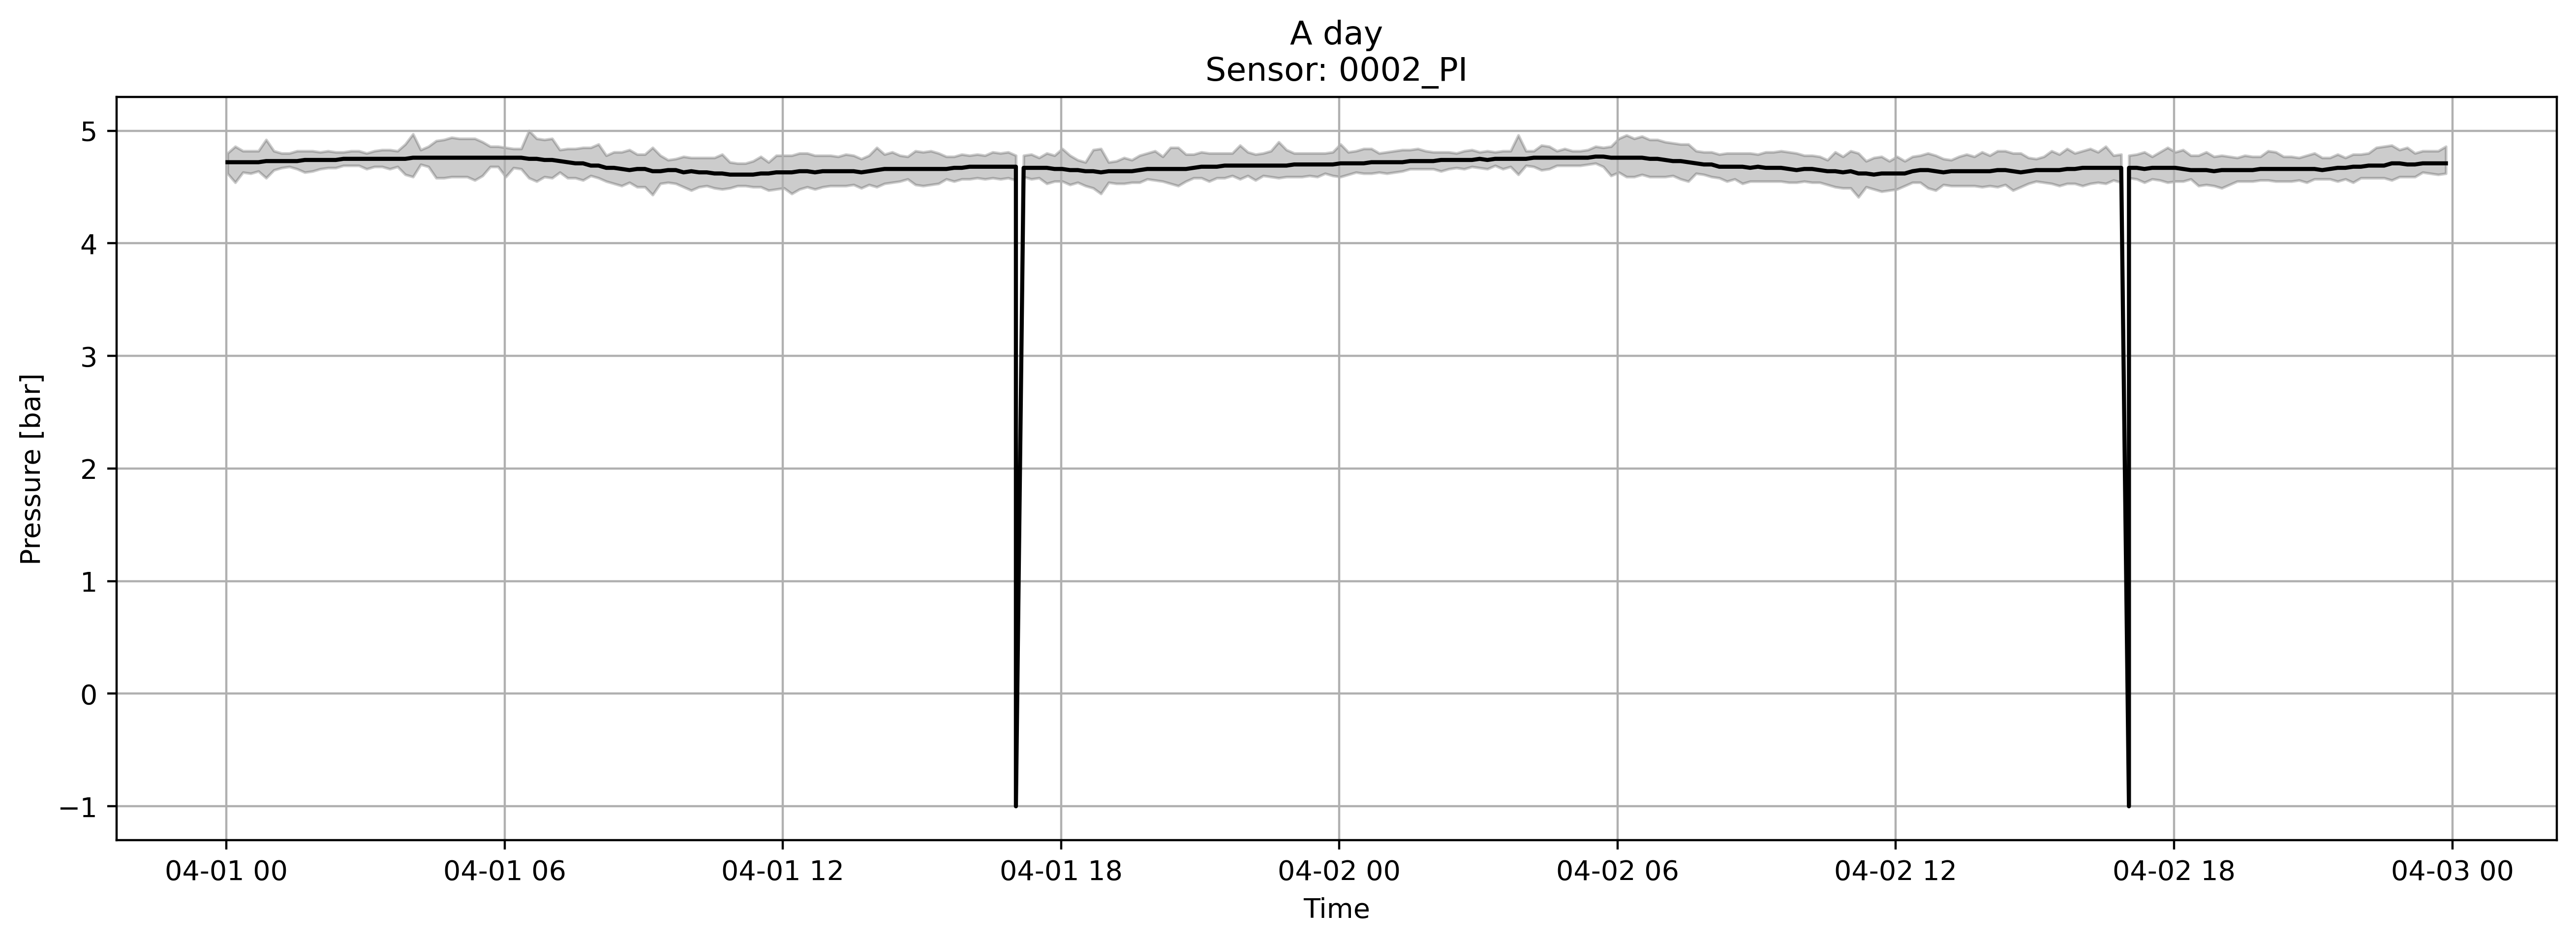

In [17]:
ax = interval_plot(x       = dfs['0002_PI']['2020-04-01':'2020-04-02'].index, 
                   y       = dfs['0002_PI']['2020-04-01':'2020-04-02']['avg'], 
                   lower   = dfs['0002_PI']['2020-04-01':'2020-04-02']['min'], 
                   upper   = dfs['0002_PI']['2020-04-01':'2020-04-02']['max'],
                   ylim    = None,
                   title   = 'A day\nSensor: 0002_PI',
                   xlabel  = 'Time',
                   ylabel  = 'Pressure [bar]',
                   color   = 'k', 
                   figsize = (16,5))

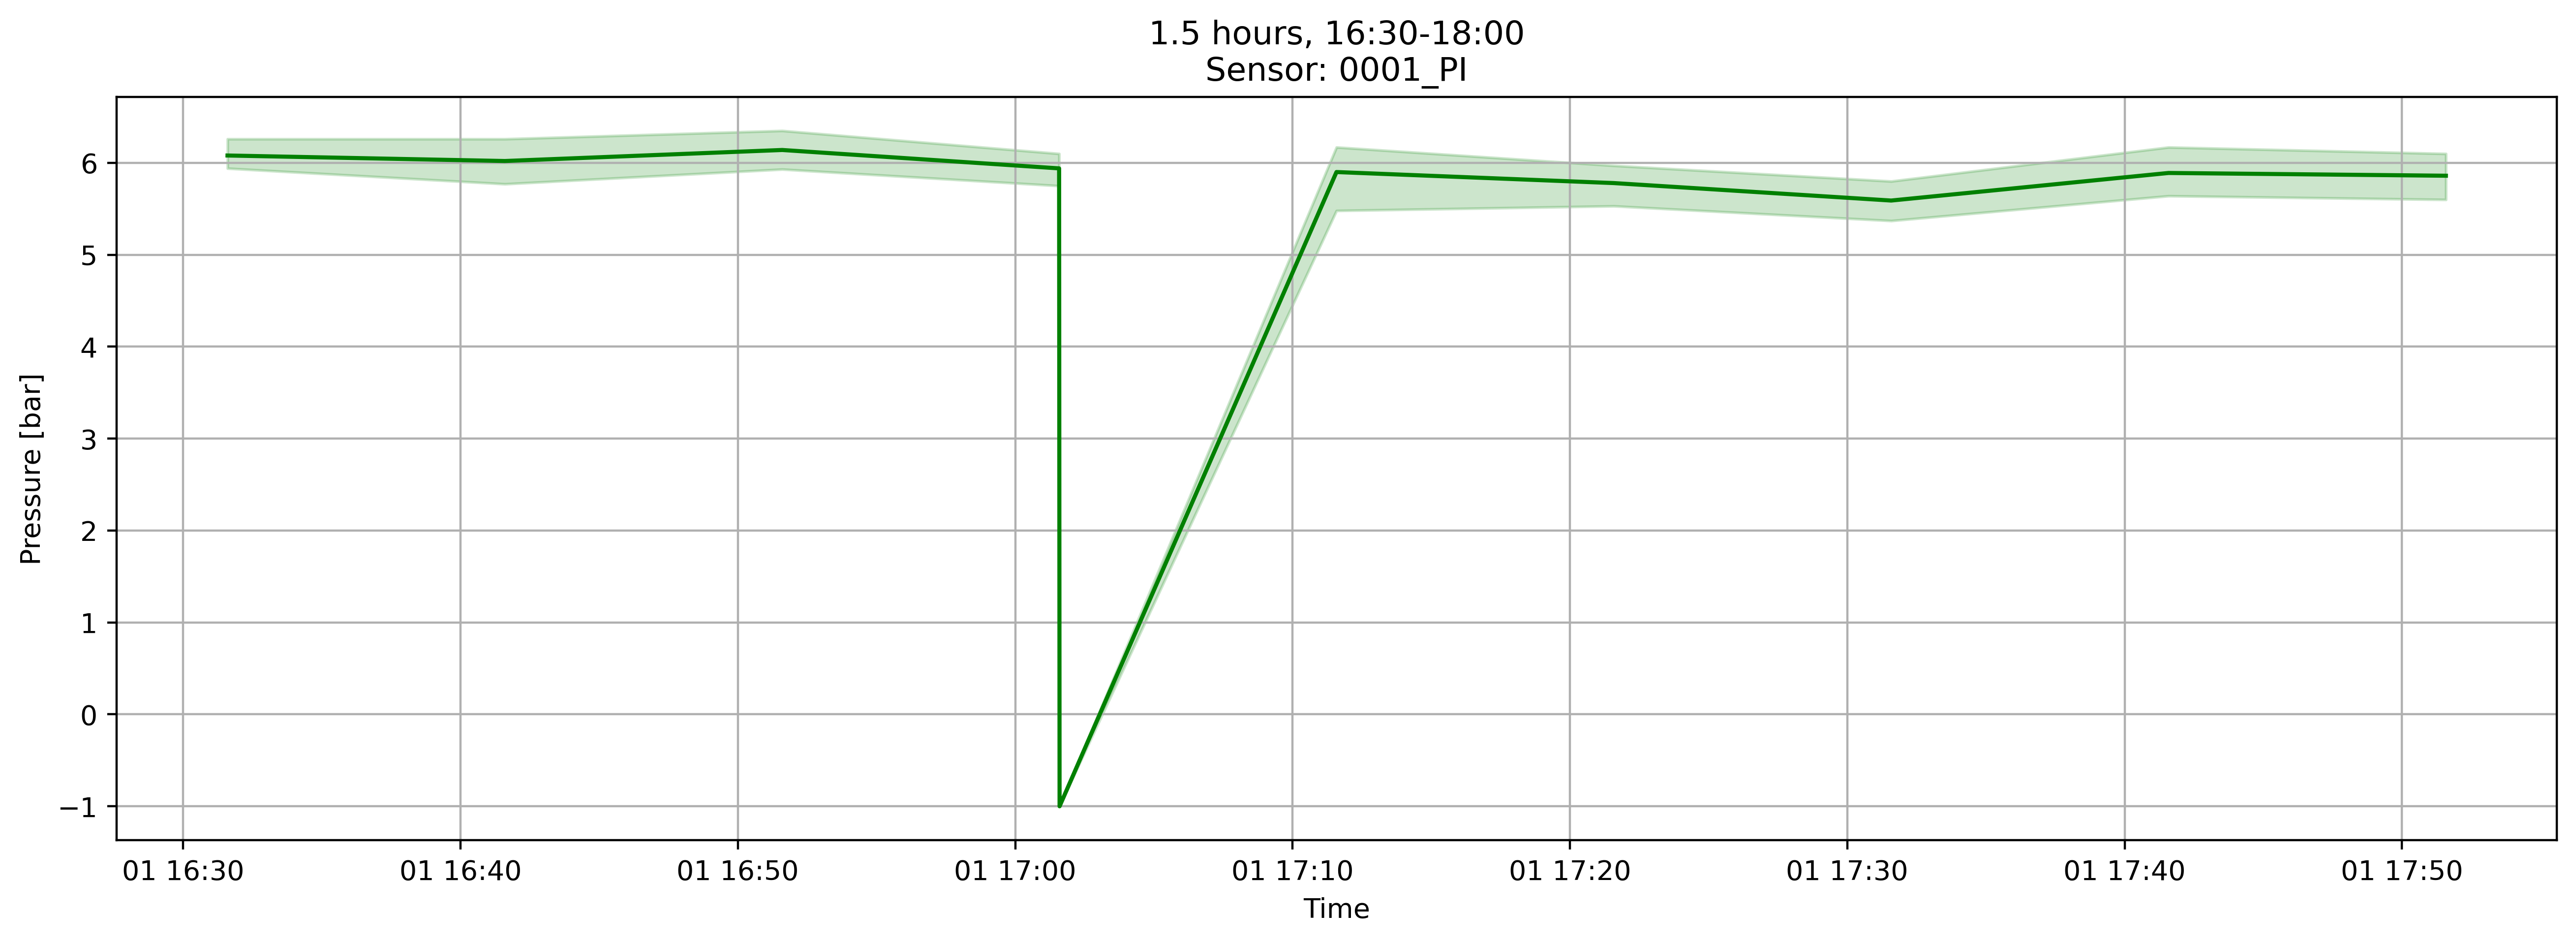

In [18]:
ax = interval_plot(x       = dfs['0001_PI']['2020-04-01 16:30':'2020-04-01 18:00'].index, 
                   y       = dfs['0001_PI']['2020-04-01 16:30':'2020-04-01 18:00']['avg'], 
                   lower   = dfs['0001_PI']['2020-04-01 16:30':'2020-04-01 18:00']['min'], 
                   upper   = dfs['0001_PI']['2020-04-01 16:30':'2020-04-01 18:00']['max'],
                   ylim    = None,
                   title   = '1.5 hours, 16:30-18:00\nSensor: 0001_PI',
                   xlabel  = 'Time',
                   ylabel  = 'Pressure [bar]',
                   color   = 'g', 
                   figsize = (16,5))

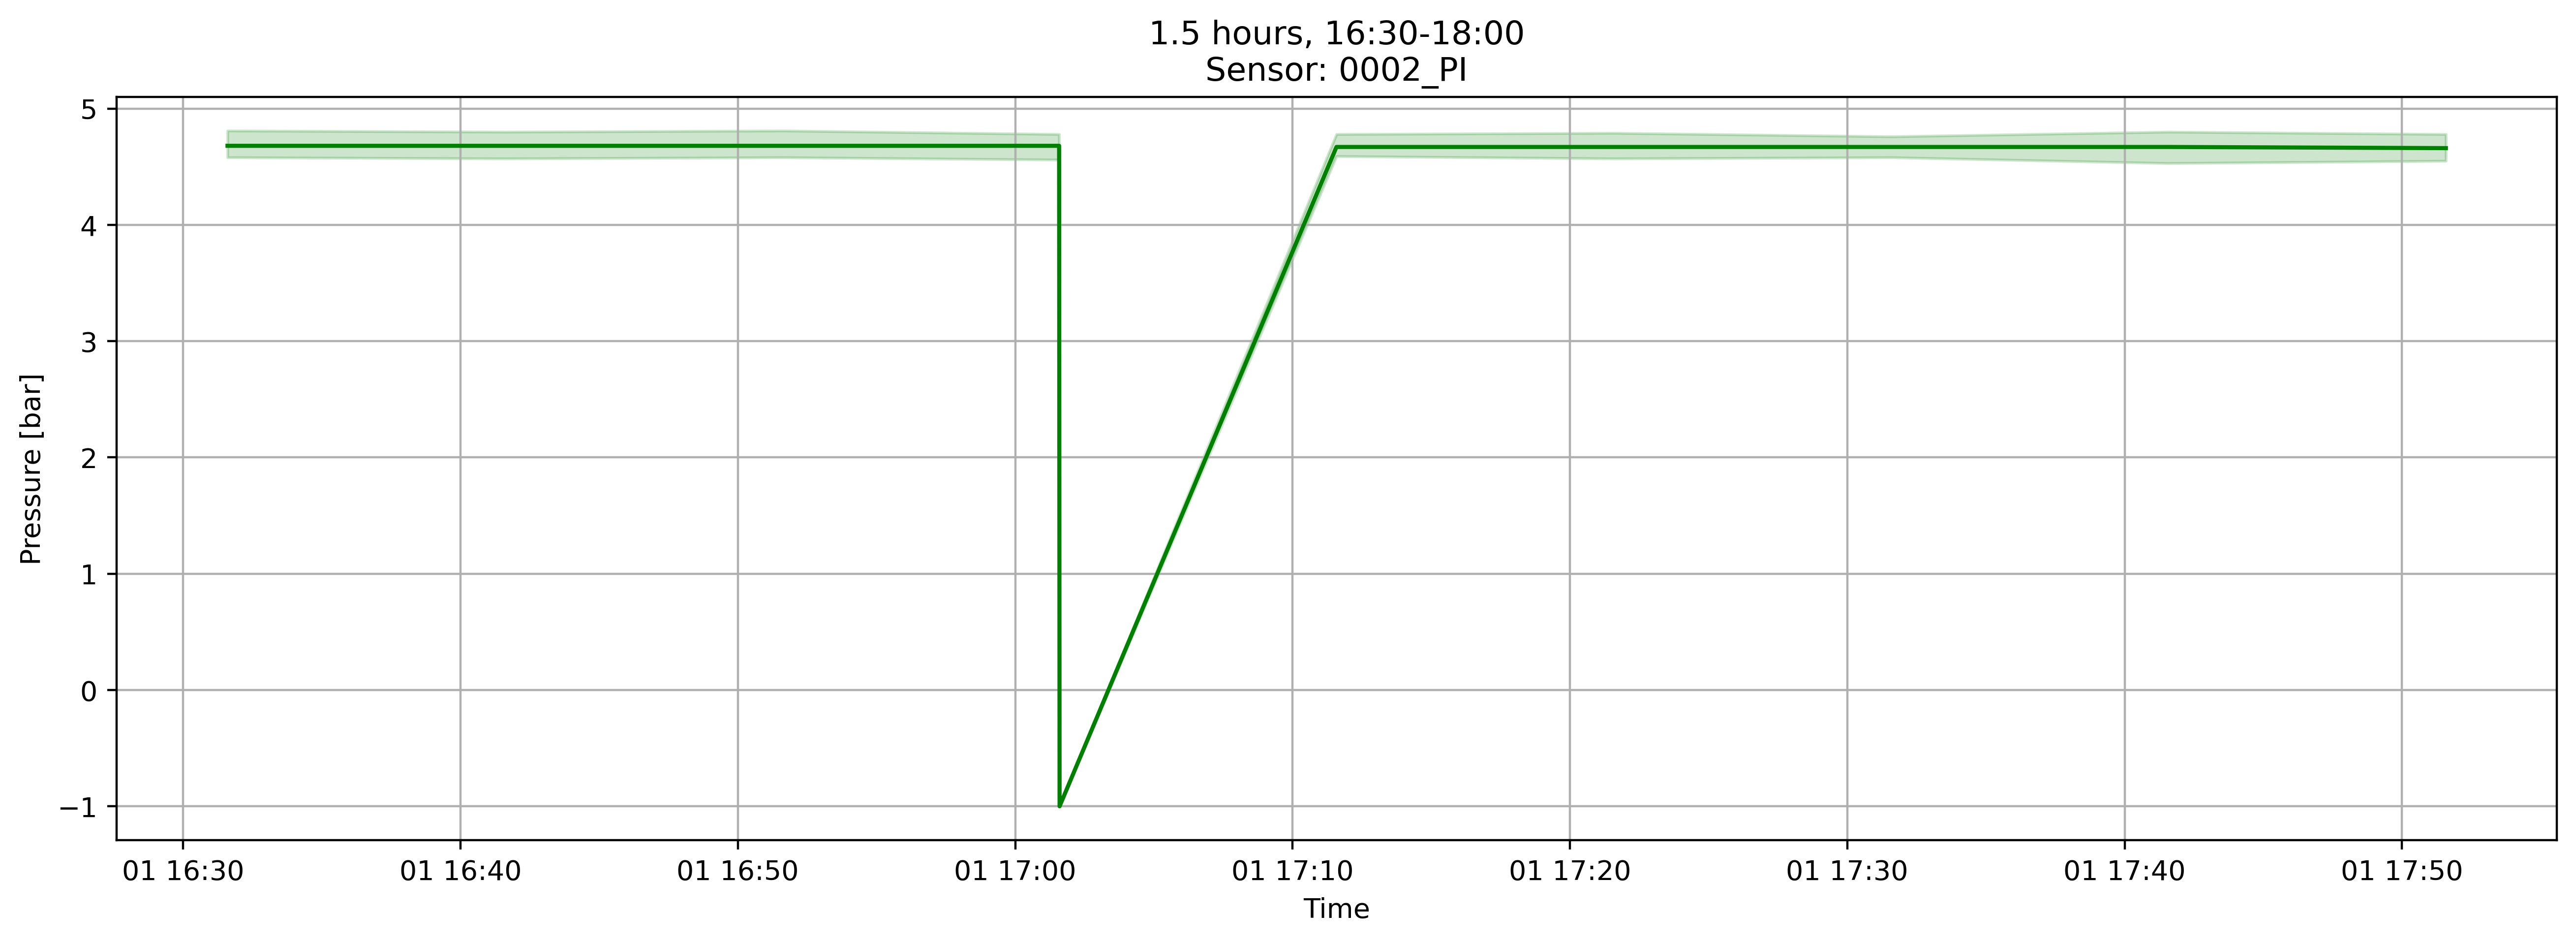

In [19]:
ax = interval_plot(x       = dfs['0002_PI']['2020-04-01 16:30':'2020-04-01 18:00'].index, 
                   y       = dfs['0002_PI']['2020-04-01 16:30':'2020-04-01 18:00']['avg'], 
                   lower   = dfs['0002_PI']['2020-04-01 16:30':'2020-04-01 18:00']['min'], 
                   upper   = dfs['0002_PI']['2020-04-01 16:30':'2020-04-01 18:00']['max'],
                   ylim    = None,
                   title   = '1.5 hours, 16:30-18:00\nSensor: 0002_PI',
                   xlabel  = 'Time',
                   ylabel  = 'Pressure [bar]',
                   color   = 'g', 
                   figsize = (16,5))

This seems a little too systematic for it to be a naturally occuring phenomena, I would rather think that this may be down to, e.g. regular servicing of data acquisition software such as restarts of OPC server or some database maintenance task being run.

In [20]:
def multi_plot(x, y, lower, upper, ylim=None, n_figs=(1,1), title='', xlabel='', ylabel='', color='r', figsize=(16,8), axes=None):
    
    if axes is None:
        fig, axes = plt.subplots(nrows=n_figs[0], ncols=n_figs[1], sharex=True, sharey=False, figsize=figsize, dpi=400)
        
    for i, ax in enumerate(axes):
        ax.set_title(title[i])
        ax.set_ylabel(ylabel[i])
        
        # Set y-boundary if defined
        if ylim is not None:    
            ax.set_ylim(*ylim)
        
        # The last subfigure has the x-label
        if i == n_figs[0]: 
            ax.set_xlabel(xlabel)
        
        ax.grid()
        ax.fill_between(x, lower[i], upper[i], alpha=0.2, color=color[i])
        ax.plot(x, y[i], color=color[i])
    
    return axes

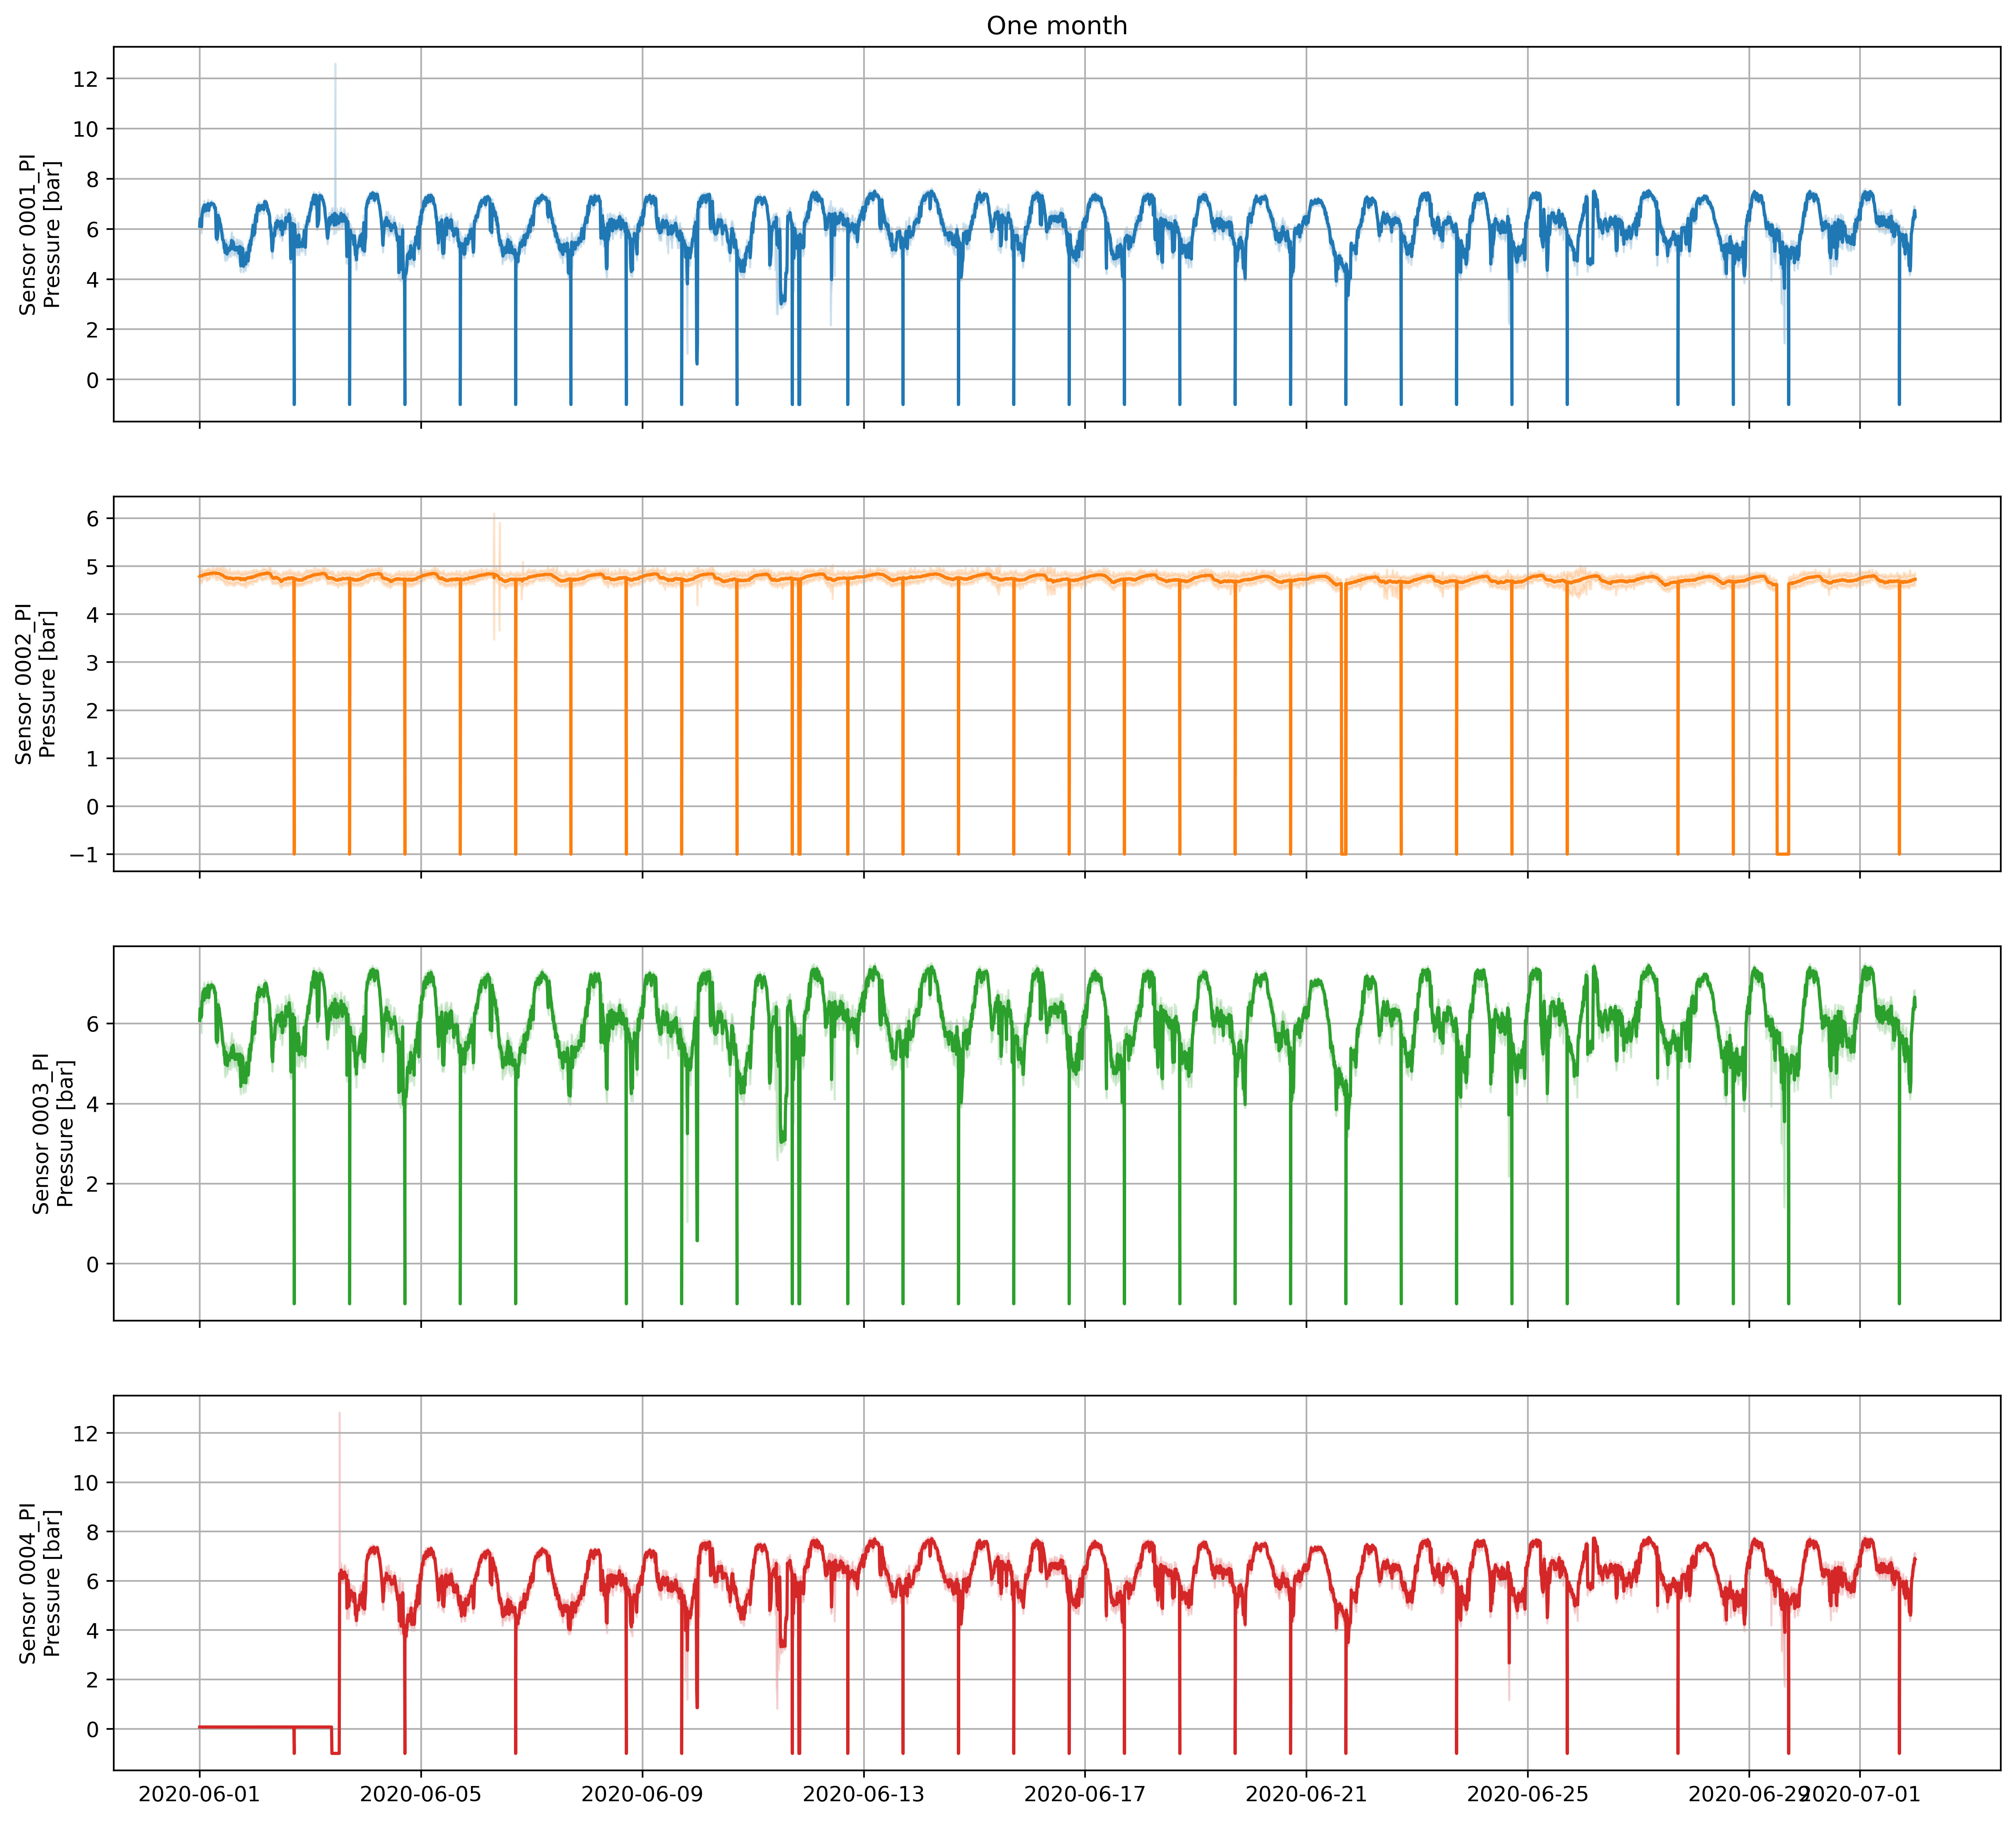

In [21]:
start = '2020-06-01'
stop  = '2020-07-01'
time  =  dfs['0001_PI'][start:stop].index

lines = [dfs['0001_PI'][start:stop]['avg'],
         dfs['0002_PI'][start:stop]['avg'],
         dfs['0003_PI'][start:stop]['avg'],
         dfs['0004_PI'][start:stop]['avg']]

lower = [dfs['0001_PI'][start:stop]['min'],
         dfs['0002_PI'][start:stop]['min'],
         dfs['0003_PI'][start:stop]['min'],
         dfs['0004_PI'][start:stop]['min']]

upper = [dfs['0001_PI'][start:stop]['max'],
         dfs['0002_PI'][start:stop]['max'],
         dfs['0003_PI'][start:stop]['max'],
         dfs['0004_PI'][start:stop]['max']]

titles = ['One month',None,None,None]
[]
y_labels = ['Sensor 0001_PI\nPressure [bar]', 
            'Sensor 0002_PI\nPressure [bar]', 
            'Sensor 0003_PI\nPressure [bar]', 
            'Sensor 0004_PI\nPressure [bar]']

ax = multi_plot(x       = time,
                y       = lines,
                lower   = lower, 
                upper   = upper,
                ylim    = None,
                n_figs  = (4,1),
                title   = titles,
                xlabel  = 'Time',
                ylabel  = y_labels,
                color   = sns.color_palette()[0:4], 
                figsize = (16,15))

Let's check for trends, remove daily seasonality with moving average plots

In [22]:
start  = '2020-07-03'
stop   = '2020-07-04'
print('How many measurements do we have in a single day?')
dfs['0001_PI'][start:stop].count()

How many measurements do we have in a single day?


avg      289
max      288
min      288
q_avg    289
q_max    288
q_min    288
dtype: int64

Let's set that as a window for a moving average plot

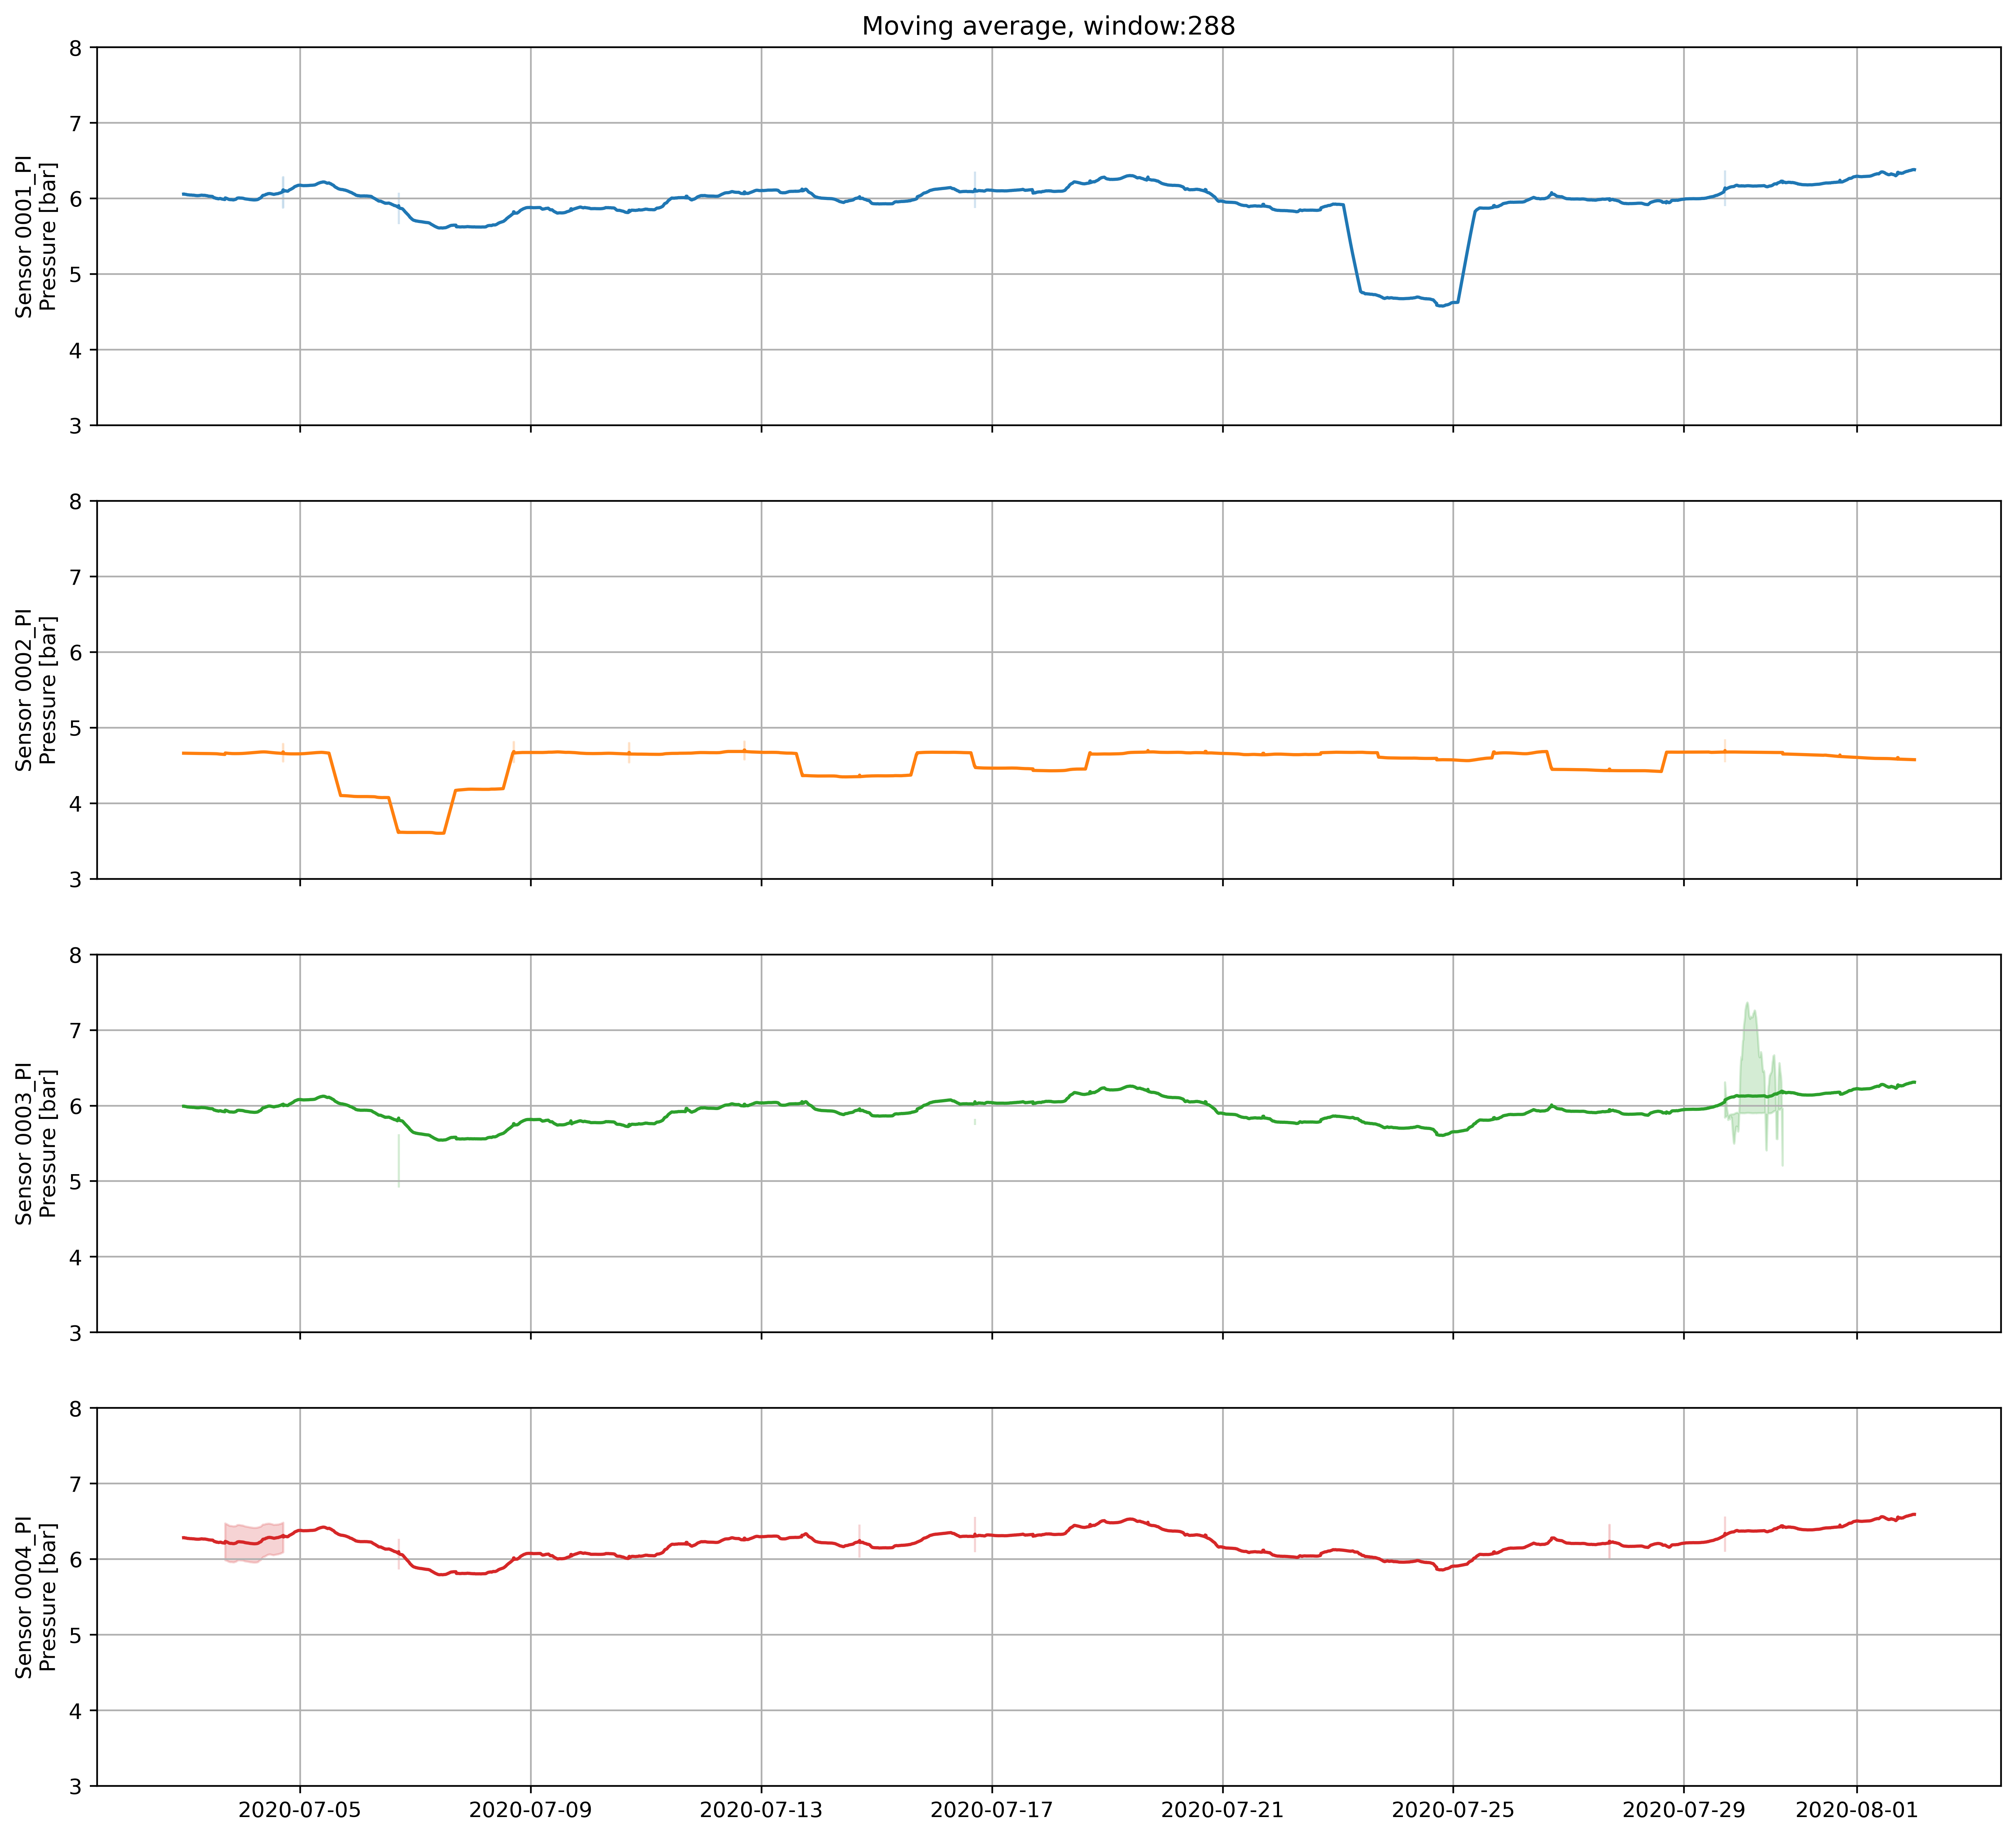

In [23]:
start  = '2020-07-01'
stop   = '2020-08-01'
window = 288
time   =  dfs['0001_PI'][start:stop].index

lines = [dfs['0001_PI'][start:stop]['avg'].rolling(window=window).mean(),
         dfs['0002_PI'][start:stop]['avg'].rolling(window=window).mean(),
         dfs['0003_PI'][start:stop]['avg'].rolling(window=window).mean(),
         dfs['0004_PI'][start:stop]['avg'].rolling(window=window).mean()]

lower = [dfs['0001_PI'][start:stop]['min'].rolling(window=window).mean(),
         dfs['0002_PI'][start:stop]['min'].rolling(window=window).mean(),
         dfs['0003_PI'][start:stop]['min'].rolling(window=window).mean(),
         dfs['0004_PI'][start:stop]['min'].rolling(window=window).mean()]

upper = [dfs['0001_PI'][start:stop]['max'].rolling(window=window).mean(),
         dfs['0002_PI'][start:stop]['max'].rolling(window=window).mean(),
         dfs['0003_PI'][start:stop]['max'].rolling(window=5).mean(),
         dfs['0004_PI'][start:stop]['max'].rolling(window=window).mean()]

titles = ['Moving average, window:{}'.format(window),None,None,None]

y_labels = ['Sensor 0001_PI\nPressure [bar]', 
            'Sensor 0002_PI\nPressure [bar]', 
            'Sensor 0003_PI\nPressure [bar]', 
            'Sensor 0004_PI\nPressure [bar]']

ax = multi_plot(x       = time,
                y       = lines,
                lower   = lower, 
                upper   = upper,
                ylim    = (3,8),
                n_figs  = (4,1),
                title   = titles,
                xlabel  = 'Time',
                ylabel  = y_labels,
                color   = sns.color_palette()[0:4], 
                figsize = (16,15))

There seems to be an interesting pressure surge on sensor `0001_PI` on or around the `2020-07-23`

Let's do some checks on missing data

<AxesSubplot:ylabel='time'>

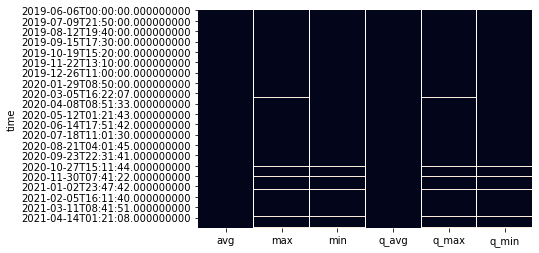

In [24]:
sns.heatmap(dfs['0001_PI'].isna(), cbar=False)

<AxesSubplot:ylabel='time'>

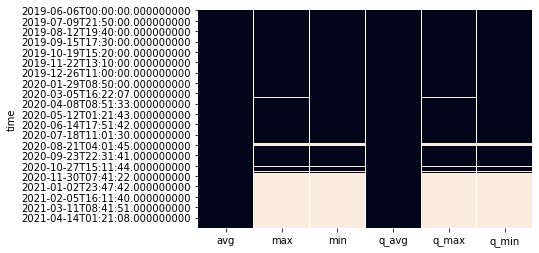

In [25]:
sns.heatmap(dfs['0002_PI'].isna(), cbar=False)

<AxesSubplot:ylabel='time'>

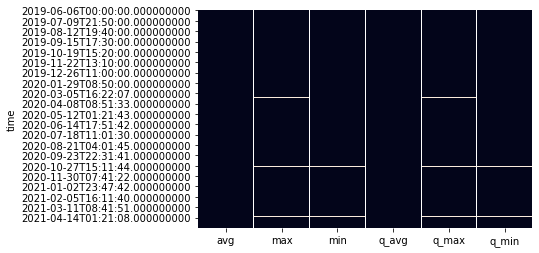

In [26]:
sns.heatmap(dfs['0003_PI'].isna(), cbar=False)

<AxesSubplot:ylabel='time'>

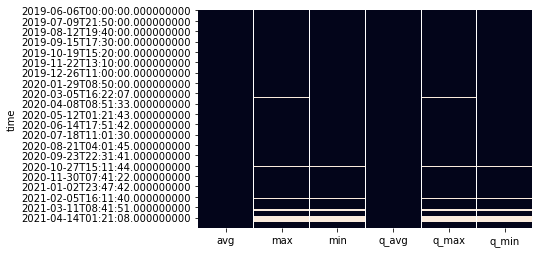

In [27]:
sns.heatmap(dfs['0004_PI'].isna(), cbar=False)

It seems there isn't a lot of `NaN` values in the `avg` column, but there are some in the `max` and `min` ones. <br>
We retrieve the indices for one of the sensors.

In [28]:
np.where(dfs['0001_PI']['avg'].isna())

(array([41387, 41388, 41389, 41390, 41391, 41392, 41393, 41394, 41395,
        41396, 41397, 41398, 41399, 41400, 41401, 41402, 41403, 41404,
        41405, 41406, 41407, 41408, 41409, 41410, 41411, 41412, 41413,
        41414, 41415, 41416, 41417, 41418, 41419, 41420, 41421, 41422,
        41423, 41424, 41425, 41426, 41427, 41428, 41429, 41430, 41431,
        41432, 41433, 41434, 41435, 41436, 41437, 41438, 41439, 41440,
        41441, 41442, 41443, 41444, 41445, 41446, 41447, 41448, 41449,
        41450, 41451, 41452, 41453, 41454, 41455, 41456, 41457, 41458,
        41459, 41460, 41461, 41462, 41463, 41464, 41465, 41466, 41467,
        41468, 41469, 41470, 41471, 41472, 41473, 41474, 41475, 41476,
        41477, 41478, 41479, 41480, 41481, 41482, 41483, 41484, 41485,
        41486, 41487, 41488, 41489, 41490, 41491, 41492, 41493, 41494,
        41495, 41496, 41497, 41498, 41499, 41500, 41501, 41502, 41503,
        41504, 41505, 41506, 41507, 41508, 41509, 41510, 41511, 41512,
      

We notice this is a continuous interval. <br>
Let's plot the surrounding timerange.

<AxesSubplot:xlabel='time'>

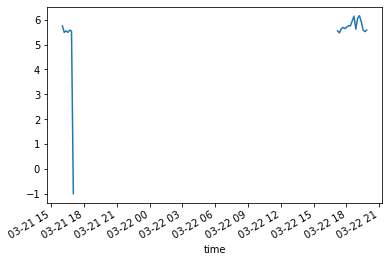

In [29]:
dfs['0001_PI']['avg'].iloc[41380:41550].plot()

We see a total blackout for one day.
Is this infact sensor specific or was something going on in the backend?

In [30]:
np.where(dfs['0002_PI']['avg'].isna())

(array([41387, 41388, 41389, 41390, 41391, 41392, 41393, 41394, 41395,
        41396, 41397, 41398, 41399, 41400, 41401, 41402, 41403, 41404,
        41405, 41406, 41407, 41408, 41409, 41410, 41411, 41412, 41413,
        41414, 41415, 41416, 41417, 41418, 41419, 41420, 41421, 41422,
        41423, 41424, 41425, 41426, 41427, 41428, 41429, 41430, 41431,
        41432, 41433, 41434, 41435, 41436, 41437, 41438, 41439, 41440,
        41441, 41442, 41443, 41444, 41445, 41446, 41447, 41448, 41449,
        41450, 41451, 41452, 41453, 41454, 41455, 41456, 41457, 41458,
        41459, 41460, 41461, 41462, 41463, 41464, 41465, 41466, 41467,
        41468, 41469, 41470, 41471, 41472, 41473, 41474, 41475, 41476,
        41477, 41478, 41479, 41480, 41481, 41482, 41483, 41484, 41485,
        41486, 41487, 41488, 41489, 41490, 41491, 41492, 41493, 41494,
        41495, 41496, 41497, 41498, 41499, 41500, 41501, 41502, 41503,
        41504, 41505, 41506, 41507, 41508, 41509, 41510, 41511, 41512,
      

In [31]:
np.where(dfs['0003_PI']['avg'].isna())

(array([41387, 41388, 41389, 41390, 41391, 41392, 41393, 41394, 41395,
        41396, 41397, 41398, 41399, 41400, 41401, 41402, 41403, 41404,
        41405, 41406, 41407, 41408, 41409, 41410, 41411, 41412, 41413,
        41414, 41415, 41416, 41417, 41418, 41419, 41420, 41421, 41422,
        41423, 41424, 41425, 41426, 41427, 41428, 41429, 41430, 41431,
        41432, 41433, 41434, 41435, 41436, 41437, 41438, 41439, 41440,
        41441, 41442, 41443, 41444, 41445, 41446, 41447, 41448, 41449,
        41450, 41451, 41452, 41453, 41454, 41455, 41456, 41457, 41458,
        41459, 41460, 41461, 41462, 41463, 41464, 41465, 41466, 41467,
        41468, 41469, 41470, 41471, 41472, 41473, 41474, 41475, 41476,
        41477, 41478, 41479, 41480, 41481, 41482, 41483, 41484, 41485,
        41486, 41487, 41488, 41489, 41490, 41491, 41492, 41493, 41494,
        41495, 41496, 41497, 41498, 41499, 41500, 41501, 41502, 41503,
        41504, 41505, 41506, 41507, 41508, 41509, 41510, 41511, 41512,
      

In [32]:
np.where(dfs['0004_PI']['avg'].isna())

(array([41387, 41388, 41389, 41390, 41391, 41392, 41393, 41394, 41395,
        41396, 41397, 41398, 41399, 41400, 41401, 41402, 41403, 41404,
        41405, 41406, 41407, 41408, 41409, 41410, 41411, 41412, 41413,
        41414, 41415, 41416, 41417, 41418, 41419, 41420, 41421, 41422,
        41423, 41424, 41425, 41426, 41427, 41428, 41429, 41430, 41431,
        41432, 41433, 41434, 41435, 41436, 41437, 41438, 41439, 41440,
        41441, 41442, 41443, 41444, 41445, 41446, 41447, 41448, 41449,
        41450, 41451, 41452, 41453, 41454, 41455, 41456, 41457, 41458,
        41459, 41460, 41461, 41462, 41463, 41464, 41465, 41466, 41467,
        41468, 41469, 41470, 41471, 41472, 41473, 41474, 41475, 41476,
        41477, 41478, 41479, 41480, 41481, 41482, 41483, 41484, 41485,
        41486, 41487, 41488, 41489, 41490, 41491, 41492, 41493, 41494,
        41495, 41496, 41497, 41498, 41499, 41500, 41501, 41502, 41503,
        41504, 41505, 41506, 41507, 41508, 41509, 41510, 41511, 41512,
      

All sensors have missing values for these dates. <br>
There seems to have been a system-wide, 24 hour outage.

In [33]:
dfs['0001_PI'].index

DatetimeIndex(['2019-06-06 00:00:00', '2019-06-06 00:10:00',
               '2019-06-06 00:20:00', '2019-06-06 00:30:00',
               '2019-06-06 00:40:00', '2019-06-06 00:50:00',
               '2019-06-06 01:00:00', '2019-06-06 01:10:00',
               '2019-06-06 01:20:00', '2019-06-06 01:30:00',
               ...
               '2021-05-17 15:31:11', '2021-05-17 15:41:11',
               '2021-05-17 15:51:11', '2021-05-17 16:01:11',
               '2021-05-17 16:11:11', '2021-05-17 16:21:11',
               '2021-05-17 16:31:11', '2021-05-17 16:41:11',
               '2021-05-17 16:51:11', '2021-05-17 17:01:11'],
              dtype='datetime64[ns]', name='time', length=102536, freq=None)

From the trend for sensor `0001_PI` though, it seemed these were far more common than a single day. <br>
Let's plot again the entire period for all sensors and see how many intervals we have of un-interrupted measurements.

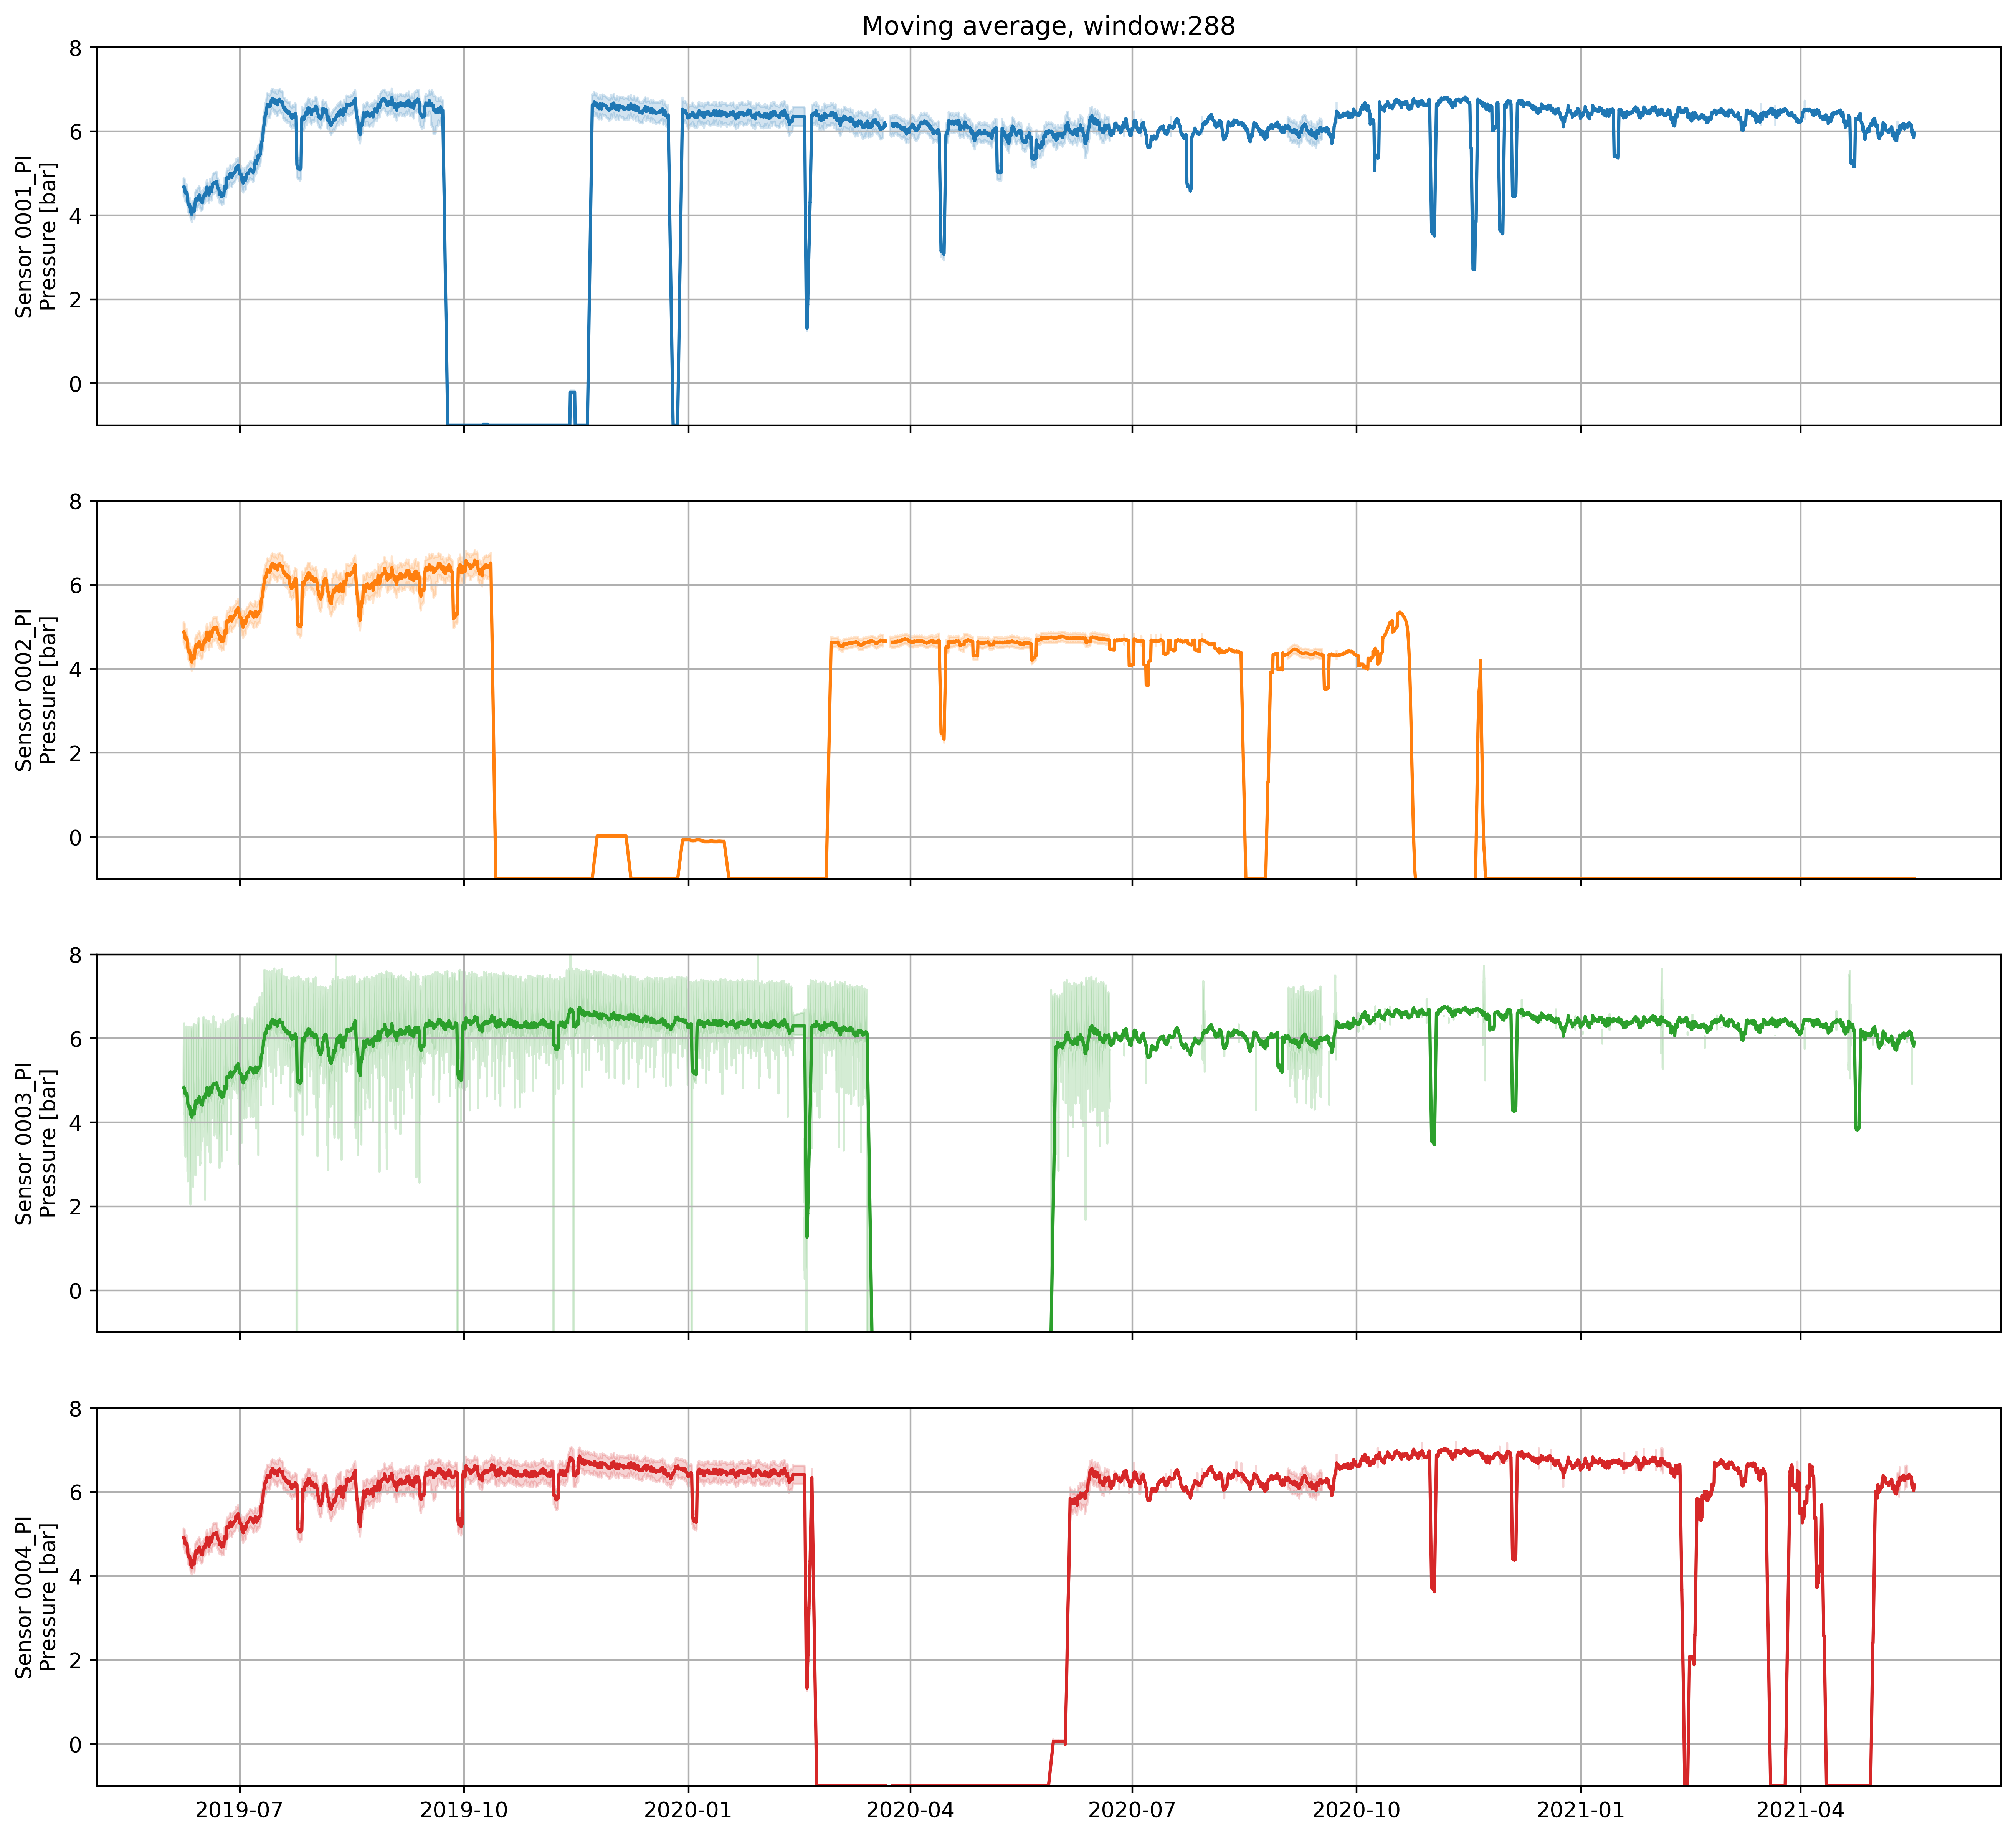

In [34]:
start  = '2019-06-06 00:00:00'
stop   = '2021-05-17 17:01:11'
window = 288
time   =  dfs['0001_PI'][start:stop].index

lines = [dfs['0001_PI'][start:stop]['avg'].rolling(window=window).mean(),
         dfs['0002_PI'][start:stop]['avg'].rolling(window=window).mean(),
         dfs['0003_PI'][start:stop]['avg'].rolling(window=window).mean(),
         dfs['0004_PI'][start:stop]['avg'].rolling(window=window).mean()]

lower = [dfs['0001_PI'][start:stop]['min'].rolling(window=window).mean(),
         dfs['0002_PI'][start:stop]['min'].rolling(window=window).mean(),
         dfs['0003_PI'][start:stop]['min'].rolling(window=window).mean(),
         dfs['0004_PI'][start:stop]['min'].rolling(window=window).mean()]

upper = [dfs['0001_PI'][start:stop]['max'].rolling(window=window).mean(),
         dfs['0002_PI'][start:stop]['max'].rolling(window=window).mean(),
         dfs['0003_PI'][start:stop]['max'].rolling(window=5).mean(),
         dfs['0004_PI'][start:stop]['max'].rolling(window=window).mean()]

titles = ['Moving average, window:{}'.format(window),None,None,None]

y_labels = ['Sensor 0001_PI\nPressure [bar]', 
            'Sensor 0002_PI\nPressure [bar]', 
            'Sensor 0003_PI\nPressure [bar]', 
            'Sensor 0004_PI\nPressure [bar]']

ax = multi_plot(x       = time,
                y       = lines,
                lower   = lower, 
                upper   = upper,
                ylim    = (-1,8),
                n_figs  = (4,1),
                title   = titles,
                xlabel  = 'Time',
                ylabel  = y_labels,
                color   = sns.color_palette()[0:4], 
                figsize = (16,15))

OK, it's apparent there is far fewer usable, or continuous uninterrupted measurements from this. <br>
Still, it might be worth developing the algorithm so that it is robust towards these kind of interruptions.

/opt/anaconda3/envs/GraphBasedLearning/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/GraphBasedLearning/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/GraphBasedLearning/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a fi

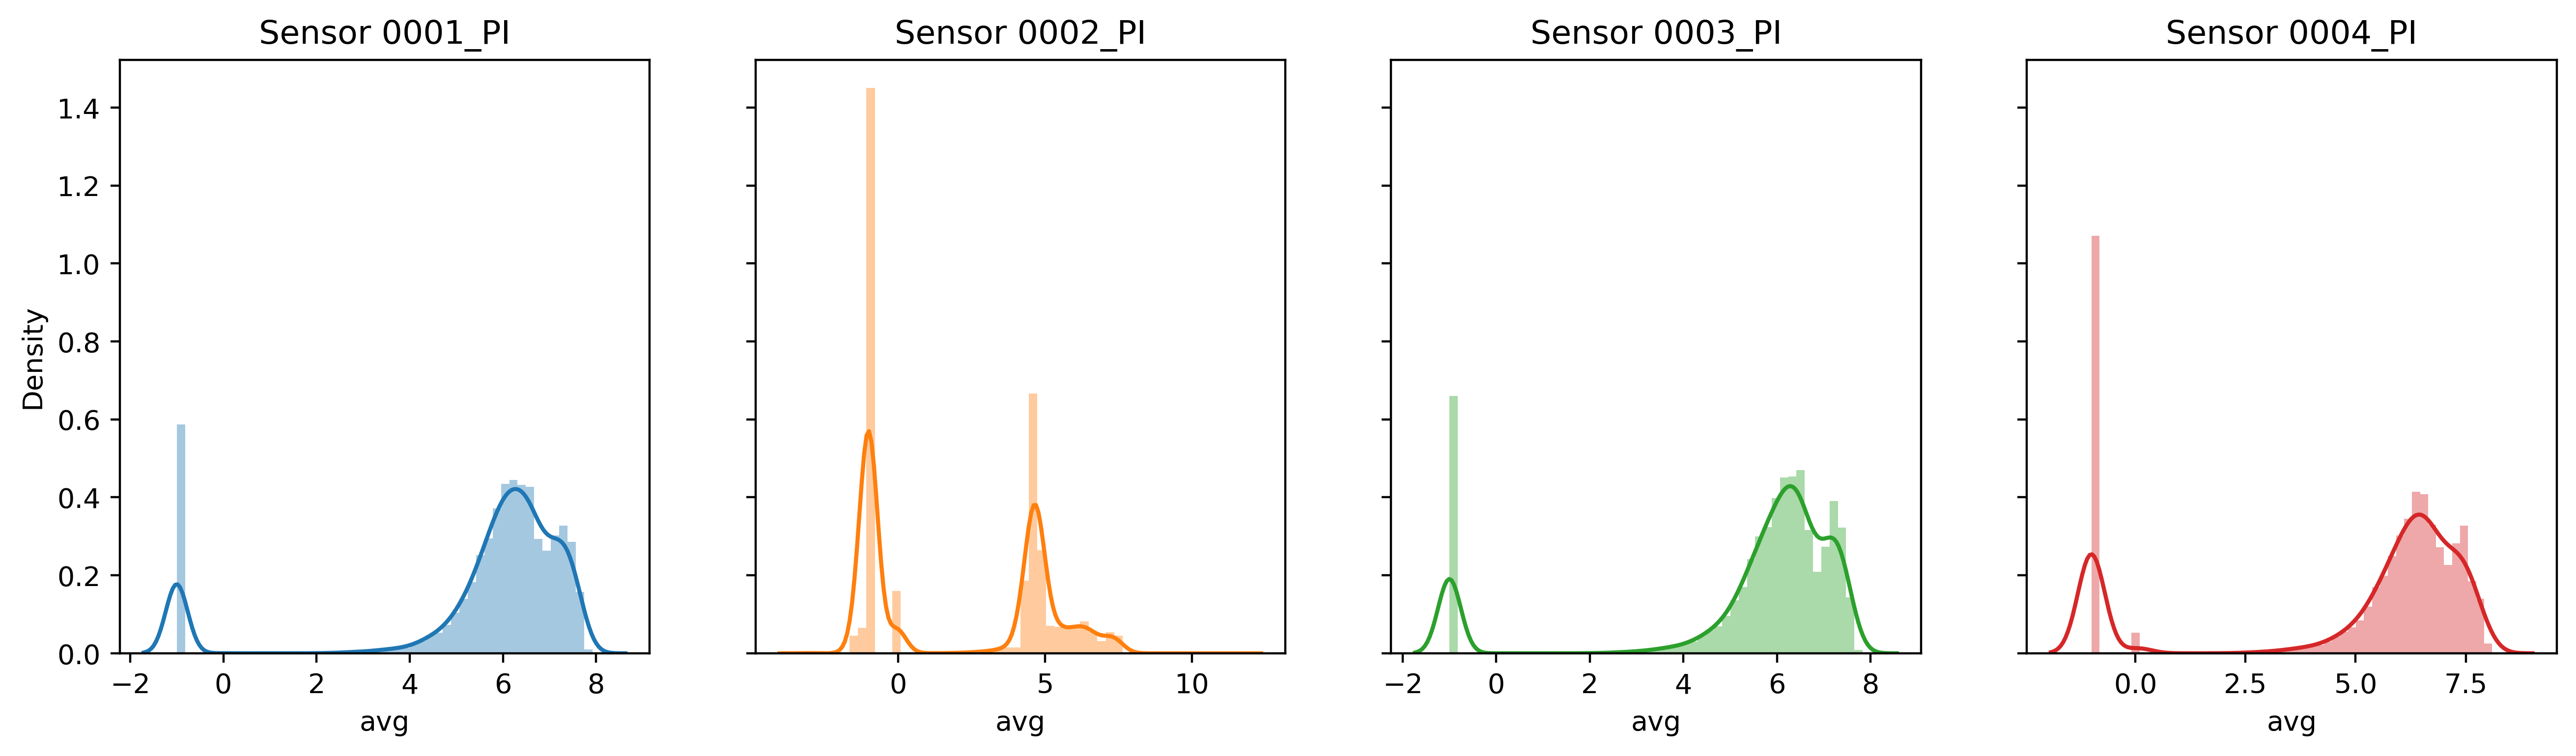

In [35]:
fig,ax = plt.subplots(ncols=4,nrows=1,sharey=True,figsize=(16,4),dpi=400)
sns.distplot(dfs['0001_PI'][start:stop]['avg'],ax=ax[0],color=sns.color_palette()[0])
sns.distplot(dfs['0002_PI'][start:stop]['avg'],ax=ax[1],color=sns.color_palette()[1])
sns.distplot(dfs['0003_PI'][start:stop]['avg'],ax=ax[2],color=sns.color_palette()[2])
sns.distplot(dfs['0004_PI'][start:stop]['avg'],ax=ax[3],color=sns.color_palette()[3])
ax[0].set_title('Sensor 0001_PI')
ax[1].set_title('Sensor 0002_PI')
ax[2].set_title('Sensor 0003_PI')
ax[3].set_title('Sensor 0004_PI')
plt.show()

Sensor `0002_PI` seems to differ most substantially from it's partners.<br>
We need to look into this.

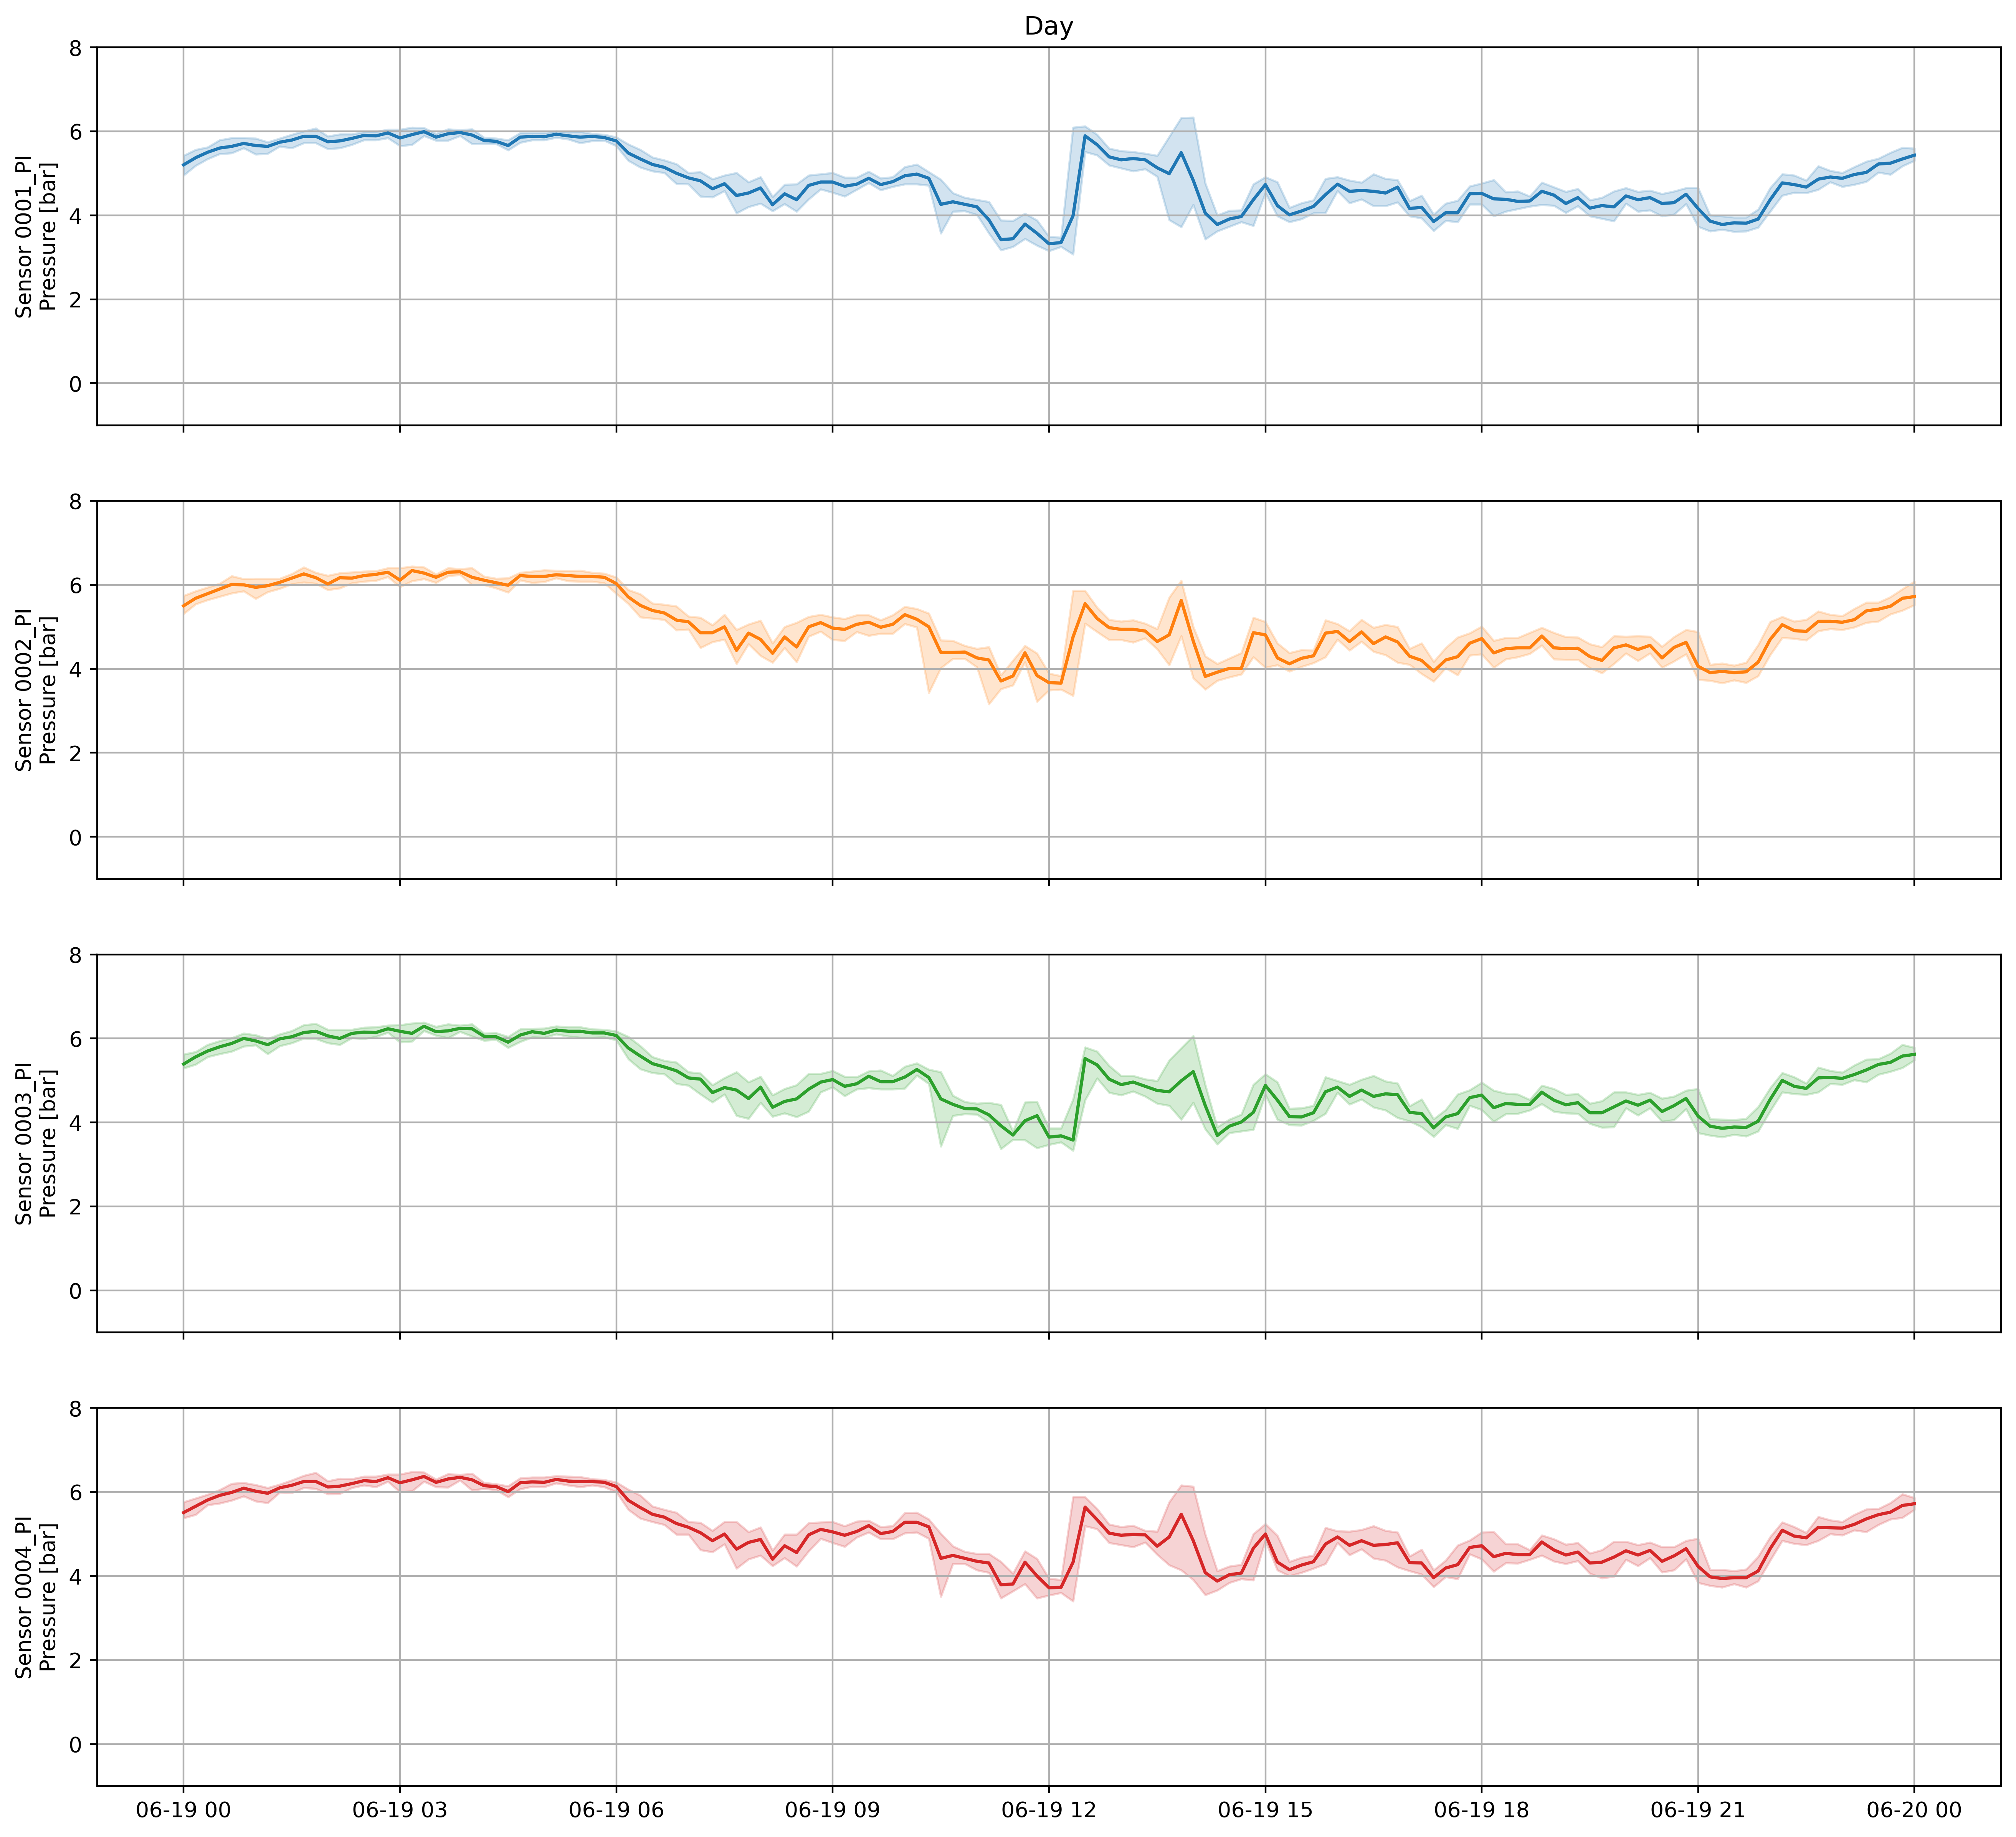

In [42]:
start  = '2019-06-19 00:00:00'
stop   = '2019-06-20 00:00:00'
window = 288
time   =  dfs['0001_PI'][start:stop].index

lines = [dfs['0001_PI'][start:stop]['avg'],
         dfs['0002_PI'][start:stop]['avg'],
         dfs['0003_PI'][start:stop]['avg'],
         dfs['0004_PI'][start:stop]['avg']]

lower = [dfs['0001_PI'][start:stop]['min'],
         dfs['0002_PI'][start:stop]['min'],
         dfs['0003_PI'][start:stop]['min'],
         dfs['0004_PI'][start:stop]['min']]

upper = [dfs['0001_PI'][start:stop]['max'],
         dfs['0002_PI'][start:stop]['max'],
         dfs['0003_PI'][start:stop]['max'],
         dfs['0004_PI'][start:stop]['max']]

titles = ['Day',None,None,None]

y_labels = ['Sensor 0001_PI\nPressure [bar]', 
            'Sensor 0002_PI\nPressure [bar]', 
            'Sensor 0003_PI\nPressure [bar]', 
            'Sensor 0004_PI\nPressure [bar]']

ax = multi_plot(x       = time,
                y       = lines,
                lower   = lower, 
                upper   = upper,
                ylim    = (-1,8),
                n_figs  = (4,1),
                title   = titles,
                xlabel  = 'Time',
                ylabel  = y_labels,
                color   = sns.color_palette()[0:4], 
                figsize = (16,15))

In [ ]:
start  = '2019-06-19 00:00:00'
stop   = '2019-06-20 00:00:00'
window = 288
time   =  dfs['0001_PI'][start:stop].index

lines = [dfs['0001_PI'][start:stop]['avg'],
         dfs['0002_PI'][start:stop]['avg'],
         dfs['0003_PI'][start:stop]['avg'],
         dfs['0004_PI'][start:stop]['avg']]

lower = [dfs['0001_PI'][start:stop]['min'],
         dfs['0002_PI'][start:stop]['min'],
         dfs['0003_PI'][start:stop]['min'],
         dfs['0004_PI'][start:stop]['min']]

upper = [dfs['0001_PI'][start:stop]['max'],
         dfs['0002_PI'][start:stop]['max'],
         dfs['0003_PI'][start:stop]['max'],
         dfs['0004_PI'][start:stop]['max']]

titles = ['Day',None,None,None]

y_labels = ['Sensor 0001_PI\nPressure [bar]', 
            'Sensor 0002_PI\nPressure [bar]', 
            'Sensor 0003_PI\nPressure [bar]', 
            'Sensor 0004_PI\nPressure [bar]']

ax = multi_plot(x       = time,
                y       = lines,
                lower   = lower, 
                upper   = upper,
                ylim    = (-1,8),
                n_figs  = (4,1),
                title   = titles,
                xlabel  = 'Time',
                ylabel  = y_labels,
                color   = sns.color_palette()[0:4], 
                figsize = (16,15))